---

<center><h1 style="font-size:40px;">U-Net Image Segmentation</h1></center>

---

In [1]:
import torch
from torch import nn
import os
from os import path
#import imageio
import imageio.v2 as imageio
import torchvision
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict
import torch.nn.functional as F
import numpy as np
import skimage.io
from skimage.io import imsave
import tqdm
from torchmetrics.functional.classification import dice
from copy import deepcopy
import albumentations as A

c:\Users\-\miniconda3\envs\-\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 11 18:18:06        
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             11W /  220W |     703MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+---------

In [4]:
training_img_dir = "data/ObjectDataset/training"
validation_img_dir = "data/ObjectDataset/validation"
testing_img_dir = "data/ObjectDataset/testing"

In [5]:
# In the ground truth we have three different shapes and background with different colors:
# squares = red = ff0000 = 255, 0, 0
# triangles = green = 00ff00 = 0, 255, 0
# circles = blue = 0000ff = 0, 0, 255
# background = black = 000000 = 0, 0, 0

# RGB to class index mapping
rgb_class_map = {
    (255, 0, 0): 0,  # Red to class 0
    (0, 255, 0): 1,  # Green to class 1
    (0, 0, 255): 2,  # Blue to class 2
    (0, 0, 0): 3     # Black to class 3

}

# Class index to RGB mapping
class_rgb_map = {
    0: (255, 0, 0),  # Class 0 to red
    1: (0, 255, 0),  # Class 1 to green
    2: (0, 0, 255),  # Class 2 to blue
    3: (0, 0, 0)     # Class 3 to black
}

def rgb_to_class(image, rgb_class_map=rgb_class_map):
    # Create an empty array for class indices
    class_index_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    # Iterate over the RGB to class index mapping
    for rgb, class_index in rgb_class_map.items():
        # Find pixels matching the current RGB color
        bool_mask = np.all(image == rgb, axis=-1)
        # Assign the corresponding class index to the pixels
        class_index_image[bool_mask] = class_index
    return class_index_image

def class_to_rgb(img_classes, class_rgb_map=class_rgb_map):
    # Create an empty array for the RGB image
    reconstructed_image = np.zeros((img_classes.shape[0], img_classes.shape[1], 3), dtype=np.uint8)
    # Iterate over the class index to RGB mapping
    for class_index, rgb in class_rgb_map.items():
        # Find pixels matching the current class index
        bool_mask = img_classes == class_index
        # Assign the corresponding RGB color to the pixels
        reconstructed_image[bool_mask] = rgb
    return reconstructed_image


# The functions below were working just fine and are easy to understand
# BUT they were super slow on large amounts of data
'''
def rgb_to_class(image, rgb_class_map=rgb_class_map):
  # Create an empty array for class indices
  class_index_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
  # Iterate over each pixel
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          rgb = tuple(image[i, j][:3])
          if rgb in rgb_class_map:
              class_index_image[i, j] = rgb_class_map[rgb]
  return class_index_image

def class_to_rgb(img_classes, class_rgb_map=class_rgb_map):
  # Create an empty array for the RGB image
  reconstructed_image = np.zeros((img_classes.shape[0], img_classes.shape[1], 3), dtype=np.uint8)
  # Iterate over each pixel
  for i in range(img_classes.shape[0]):
      for j in range(img_classes.shape[1]):
          class_index = img_classes[i, j]
          if class_index in class_rgb_map:
              reconstructed_image[i, j] = class_rgb_map[class_index]
  return reconstructed_image
'''

'\ndef rgb_to_class(image, rgb_class_map=rgb_class_map):\n  # Create an empty array for class indices\n  class_index_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)\n  # Iterate over each pixel\n  for i in range(image.shape[0]):\n      for j in range(image.shape[1]):\n          rgb = tuple(image[i, j][:3])\n          if rgb in rgb_class_map:\n              class_index_image[i, j] = rgb_class_map[rgb]\n  return class_index_image\n\ndef class_to_rgb(img_classes, class_rgb_map=class_rgb_map):\n  # Create an empty array for the RGB image\n  reconstructed_image = np.zeros((img_classes.shape[0], img_classes.shape[1], 3), dtype=np.uint8)\n  # Iterate over each pixel\n  for i in range(img_classes.shape[0]):\n      for j in range(img_classes.shape[1]):\n          class_index = img_classes[i, j]\n          if class_index in class_rgb_map:\n              reconstructed_image[i, j] = class_rgb_map[class_index]\n  return reconstructed_image\n'

In [ ]:
class Objects(torch.utils.data.Dataset):
    """Dataset to  Object Dataset for the segmentation task.
    """
    def __init__(self, root, transform=None):
        super(Objects,self).__init__()
        self.root = root
        self.transform = transform

        self.images = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/image')) for f in fn if f.endswith(".png")]
        self.images.sort()

        self.images_gt_class = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/gt_image')) for f in fn if f.endswith(".png")]
        self.images_gt_class.sort()

        self.images_gt = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/gt_image')) for f in fn if f.endswith(".png")]
        self.images_gt.sort()

    def __getitem__(self, index):
        # get data
        x = imageio.imread(self.images[index])
        y = imageio.imread(self.images_gt_class[index])
        z = imageio.imread(self.images_gt[index])
        if self.transform:
            transformed = self.transform(image=x, image0=y, image1=z)
            x = transformed['image']
            y = transformed['image0']
            z = transformed['image1']
            x = torch.from_numpy(x)
            y = torch.from_numpy(y)
            z = torch.from_numpy(z)
        else:
            x = torch.from_numpy(x)
            y = torch.from_numpy(y)
            z = torch.from_numpy(z)

        x = x.float()

        # get ground truth as classes
        y = rgb_to_class(y.numpy())
        y = torch.from_numpy(y)
        #y = y.float()
        y = y.long()

        # get ground truth as image
        z = z.float()

        return x, y, z

    def __len__(self):
        return len(self.images)

Number of images: 10817
Datatype of tmp_img: <class 'tuple'>
Length of tmp_img: 3
Datatype of tmp_img[0]: <class 'torch.Tensor'>
Shape of tmp_img[0]: torch.Size([128, 128, 3])
Datatype of tensor tmp_img[0]: torch.float32
Datatype of tmp_img[1]: <class 'torch.Tensor'>
Shape of tmp_img[1]: torch.Size([128, 128])
Datatype of tensor tmp_img[1]: torch.int64
Datatype of tmp_img[2]: <class 'torch.Tensor'>
Shape of tmp_img[2]: torch.Size([128, 128, 3])
Datatype of tensor tmp_img[2]: torch.float32


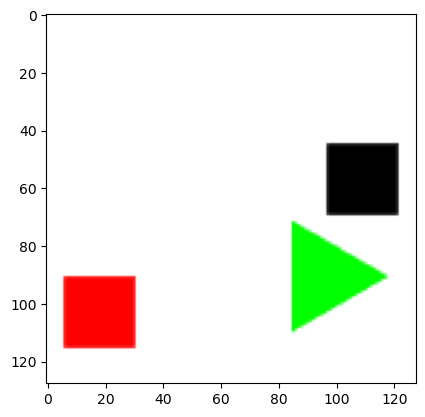

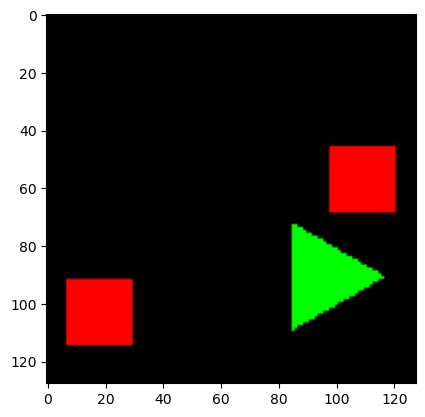

In [7]:
# Exploring the data a little
tmp__objects_train = Objects(training_img_dir)
print(f"Number of images: {tmp__objects_train.__len__()}")
tmp_img = tmp__objects_train.__getitem__(0)
print(f"Datatype of tmp_img: {type(tmp_img)}")
print(f"Length of tmp_img: {len(tmp_img)}")
print(f"Datatype of tmp_img[0]: {type(tmp_img[0])}")
print(f"Shape of tmp_img[0]: {tmp_img[0].shape}")
print(f"Datatype of tensor tmp_img[0]: {tmp_img[0].dtype}")
print(f"Datatype of tmp_img[1]: {type(tmp_img[1])}")
print(f"Shape of tmp_img[1]: {tmp_img[1].shape}")
print(f"Datatype of tensor tmp_img[1]: {tmp_img[1].dtype}")
print(f"Datatype of tmp_img[2]: {type(tmp_img[2])}")
print(f"Shape of tmp_img[2]: {tmp_img[2].shape}")
print(f"Datatype of tensor tmp_img[2]: {tmp_img[2].dtype}")
plt.imshow(tmp_img[0].type(torch.int64).cpu().numpy())
plt.show()
plt.imshow(tmp_img[2].type(torch.int64).cpu().numpy())
plt.show()

In [7]:
def show_images(data, title:str=None, nimages:int=10, nrows:int=2, fig_dimension=1, title_size=10, ax_color='black'):
    """Creates a grid of images.
    :param data: tensor": B,W,H,C
    :param title: str:  (Default value = None)
    :param nimages: int:  (Default value = 10)
    :param nrows: int:  (Default value = 2)
    :param fig_dimension: Default value = 1)
    :param data:"tensor":
    :param title:str:  (Default value = None)
    :param nimages:int:  (Default value = 10)
    :param nrows:int:  (Default value = 2)
    """

    #data = data.permute(0,2,3,1)
    image_ratio = data[0].shape[0] /data[0].shape[1]
    if len(data)< nimages:
        nimages = len(data)

    columns = math.ceil(nimages/nrows)

    if nrows*columns > nimages:
        nrows = math.ceil(nimages/columns)

    fig = plt.figure(figsize=(fig_dimension*columns,1.4*fig_dimension*nrows*image_ratio))
    for i in range(0, nimages):
        ax = fig.add_subplot(nrows, columns, i+1)
        ax.imshow(data[i].type(torch.int64))
        #ax.set_xlabel(f"{label_prefix}{labels[i]}") if labels is not None else None
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.spines['bottom'].set_color(ax_color)
        ax.spines['top'].set_color(ax_color)
        ax.spines['right'].set_color(ax_color)
        ax.spines['left'].set_color(ax_color)

    fig.suptitle(title) #,x=0.45, y=.95

    fig.subplots_adjust(
        #left=0,
        #right=1,
        top=0.9,#+((nrows-1)*0.045),
        #bottom=0,
        wspace=0,
        #hspace=0
    )

    #plt.tight_layout(h_pad=0,w_pad=0)
    fig.tight_layout(pad=0, h_pad=0,w_pad=0)
    plt.show()

In [9]:
train_transform = None

batch_size = 32
train_loader = DataLoader(Objects(training_img_dir,transform=train_transform), batch_size=batch_size, shuffle=True)
print("Number of images in training set: ", len(train_loader)*batch_size)
print("Number of batches per epoch: ", len(train_loader))

Number of images in training set:  10848
Number of batches per epoch:  339


In [10]:
val_transform = None

batch_size = 32
val_loader = DataLoader(Objects(validation_img_dir,transform=val_transform), batch_size=batch_size)
print("Number of images in validation set: ", len(val_loader)*batch_size)
print("Number of batches per epoch: ", len(val_loader))

Number of images in validation set:  2272
Number of batches per epoch:  71


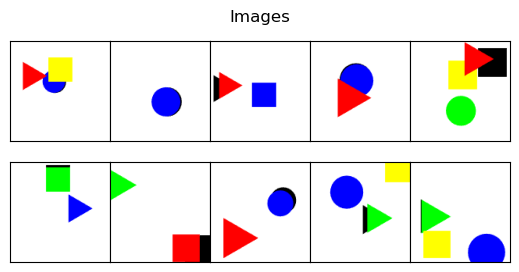

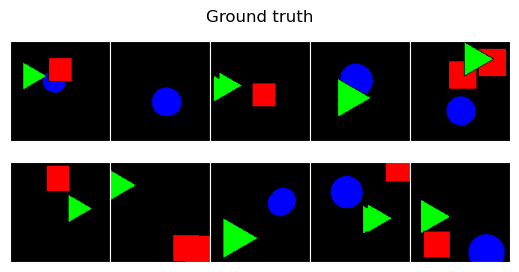

In [11]:
images, gt_class, gt_img = next(iter(train_loader))
show_images(images, title='Images')
show_images(gt_img, title='Ground truth', ax_color='white')

## Create U-Net Model

### U-Net architecture
![SegmentationArchitecture](u-net-architecture.png)  
  
Ronneberger, Olaf, et al. “U-Net: Convolutional Networks for Biomedical Image Segmentation.” _Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015_, edited by Nassir Navab et al., vol. 9351, Springer International Publishing, 2015, pp. 234–41. _DOI.org (Crossref)_, https://doi.org/10.1007/978-3-319-24574-4\_28.

In [4]:
class UnetModel(torch.nn.Module):
    def __init__(
            self, in_channels=1, num_classes=1, features=[64, 128, 256, 512],
    ):
        super(UnetModel, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels

        # Encoder
        #self.conv1 = self.Encoder(self.num_classes, 64)
        self.conv1 = self.Encoder(self.in_channels, 64)
        self.conv2 = self.Encoder(64, 128)
        self.conv3 = self.Encoder(128, 256)
        self.conv4 = self.Encoder(256, 512)

        # Bottom part
        self.conv_bottom = self.Encoder(512, 1024)

        # Decoder
        self.upconv4 = self.Decoder(1024, 512)
        self.upconv3 = self.Decoder(512, 256)
        self.upconv2 = self.Decoder(256, 128)
        # https://discuss.pytorch.org/t/unet-implementation/426/21
        # self.upconv1 = self.Decoder(128, 64)
        self.upconv1 = self.DecoderLast(128, 64)

        # Output
        self.conv_output = torch.nn.Conv2d(64, self.num_classes, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Transpose
        self.transpose4 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.transpose3 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.transpose2 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.transpose1 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    def forward(self, x):

        print_shape = True

        if print_shape:
            print('input: ')
            print(x.shape)

        # Downsample
        conv1 = self.conv1(x)
        if print_shape:
            print('conv1: ')
            print(conv1.shape)
        x = self.pool(conv1)
        if print_shape:
            print('x: ')
            print(x.shape)
        conv2 = self.conv2(x)
        if print_shape:
            print('conv2: ')
            print(conv2.shape)
        x = self.pool(conv2)
        if print_shape:
            print('x: ')
            print(x.shape)
        conv3 = self.conv3(x)
        if print_shape:
            print('conv3: ')
            print(conv3.shape)
        x = self.pool(conv3)
        if print_shape:
            print('x: ')
            print(x.shape)
        conv4 = self.conv4(x)
        if print_shape:
            print('conv4: ')
            print(conv4.shape)
        x = self.pool(conv4)
        if print_shape:
            print('x: ')
            print(x.shape)

        x = self.conv_bottom(x)
        if print_shape:
            print('conv_bottom: ')
            print(x.shape)

        # Upsample
        # https://pytorch.org/docs/stable/generated/torch.cat.html
        # Concatenates the given sequence of seq tensors in the given dimension.
        # All tensors must either have the same shape (except in the concatenating dimension) or be a 1-D empty tensor with size (0,).
        x = self.transpose4(x)
        x = self.upconv4(torch.cat((conv4,x), dim=1))
        if print_shape:
            print('upconv4: ', x.shape)
        x = self.transpose3(x)
        x = self.upconv3(torch.cat((conv3,x), dim=1))
        if print_shape:
            print('upconv3: ', x.shape)
        x = self.transpose2(x)
        x = self.upconv2(torch.cat((conv2,x), dim=1))
        if print_shape:
            print('upconv2: ', x.shape)
        x = self.transpose1(x)
        x = self.upconv1(torch.cat((conv1,x), dim=1))
        if print_shape:
            print('upconv1: ', x.shape)

        return self.conv_output(x)


    def Encoder(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def Decoder(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    # https://discuss.pytorch.org/t/unet-implementation/426/21
    def DecoderLast(self, in_channels, out_channels):
        return torch.nn.Sequential(
            #torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            #torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            #torch.nn.ReLU(inplace=True),
        )
    

def test():
    x = torch.randn((3, 3, 128, 128))
    #x = torch.randn((3, 3, 160, 160))
    model = UnetModel(in_channels=3, num_classes=4)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    #assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 4, 128, 128])
torch.Size([3, 3, 128, 128])


For using Tensorboard

In [8]:
# https://code.visualstudio.com/docs/datascience/pytorch-support
# To start a TensorBoard session, open the Command Palette (Ctrl+Shift+P) and search for the command Python: Launch TensorBoard.
# Afterwards, you'll be prompted to select the folder where your TensorBoard log files are located.

In [9]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('tensor_board_logs')

# Create train function

In [ ]:
# Copied from example code and modified

def train_epoch(epoch, optimizer, loss_fn, model, train_loader):
    """
    Trains the model for one epoch using the given training data.

    Args:
        epoch (int): The current epoch number.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss_fn (torch.nn.Module): The loss function used for calculating the loss.
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.

    Returns:
        tuple: A tuple containing the average loss and accuracy.

    This function iterates through the provided `train_loader`, computes the forward pass,
    calculates the loss, performs backpropagation, and updates the model parameters using
    the given optimizer. It then returns the average loss for the entire epoch.

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        >>> loss_fn = torch.nn.MSELoss()
        >>> train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        >>> for epoch in range(num_epochs):
        ...     epoch_loss, epoch_accuracy = train_epoch(epoch, optimizer, loss_fn, model, train_loader)
        ...     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if(epoch==0):
        print(f"Training device: {device}")
    model.to(device)

    model.train()  # Set the model to training mode
    total_loss = 0
    total_correct = 0
    total_incorrect = 0

    total_dice = 0

    for batch_idx, (xi, yi, z) in enumerate(train_loader):
        xi = xi.permute(0,3,1,2)
        xi = xi.to(device)
        yi = yi.to(device)
        optimizer.zero_grad()  # Clear gradients from previous iteration
        yp = model(xi) # Perform forward pass
        #loss = loss_fn(F.log_softmax(yp,1), yi)
        loss = loss_fn(yp, yi)

        preds = torch.argmax(yp, dim=1).squeeze().long()
        total_correct += torch.sum(preds == yi.data)
        total_incorrect += torch.sum(preds != yi.data)

        total_dice += dice(preds, yi, ignore_index=3, average='micro')

        '''
        print('preds.shapes')
        print(preds.shape)
        print('preds')
        print(preds)
        print('yi.data.shapes')
        print(yi.data.shape)
        print('yi.data')
        print(yi.data)
        print('torch.sum(preds == yi.data)')
        print(torch.sum(preds == yi.data))
        print('----------------------------------------------------------------')
        '''
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate loss for the epoch

    '''
    print('total_correct.double()')
    print(total_correct.double())
    print('total_incorrect.double()')
    print(total_incorrect.double())
    '''
    
    return (total_loss / len(train_loader)), (total_correct.double() / (total_correct.double() + total_incorrect.double())), (total_dice / len(train_loader))  # Return average loss, accuracy and dice score
    #return (total_loss / len(train_loader)), (total_correct.double() / (total_correct.double() + total_incorrect.double()))  # Return average loss and accuracy
    #return (total_loss / len(train_loader))  # Return average loss


In [ ]:
# Copied from example code and modified

def validate_epoch(epoch, loss_fn, model, val_loader):
    """
    Validates the model on the validation data for one epoch.

    Args:
        epoch (int): The current epoch number.
        loss (torch.nn.Module): The loss function used for calculating the validation loss.
        model (torch.nn.Module): The neural network model to be evaluated.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        tuple: A tuple containing the average loss and accuracy.

    This function switches the provided model to evaluation mode, iterates through the
    validation data provided by `val_loader`, computes the forward pass, and calculates
    the validation loss. It then returns the average validation loss for the entire epoch.

    Example:
        >>> loss_fn = torch.nn.MSELoss()
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> for epoch in range(num_epochs):
        ...     epoch_loss, epoch_accuracy = validate_epoch(epoch, optimizer, loss_fn, model, val_loader)
        ...     print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss:.4f}")
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if(epoch==0):
        print(f"Validation device: {device}")
    model.to(device)

    model.eval() # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_incorrect = 0

    total_dice = 0

    with torch.no_grad():
        for batch_idx, (xi, yi, z) in enumerate(val_loader):
            xi = xi.permute(0,3,1,2)
            xi = xi.to(device)
            #yi = yi.permute(0,3,1,2)
            yi = yi.to(device)
            yp = model(xi)  # Perform forward pass
            #loss = loss_fn(F.log_softmax(yp,1), yi)
            loss = loss_fn(yp, yi)

            preds = torch.argmax(yp, dim=1).squeeze().long()
            total_correct += torch.sum(preds == yi.data)
            total_incorrect += torch.sum(preds != yi.data)

            total_dice += dice(preds, yi, ignore_index=3, average='micro')

            total_loss += loss.item()

    return (total_loss / len(val_loader)), (total_correct.double() / (total_correct.double() + total_incorrect.double())), (total_dice / len(val_loader))  # Return average loss, accuracy and dice score
    #return (total_loss / len(val_loader)), (total_correct.double() / (total_correct.double() + total_incorrect.double()))  # Return average loss and accuracy
    #return (total_loss / len(val_loader))  # Return average loss

In [ ]:
# Copied from example code and modified

def a_proper_training(num_epoch, model, optimizer, loss, train_loader, val_loader):
    """
    Performs a complete training and validation process for the given model.

    Args:
        num_epoch (int): The number of training epochs.
        model (torch.nn.Module): The neural network model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss (torch.nn.Module): The loss function used for calculating the loss.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        tuple: A tuple containing the best trained model, a list of training losses for each epoch,
        a list of training accuracies for each epoch,
        a list of validation losses for each epoch and
        a list of validation accuracies for each epoch.

    This function trains the provided model for the specified number of epochs, monitoring both
    training and validation losses. It also saves the best model based on the lowest validation
    loss achieved during training.

    Example:
        >>> num_epochs = 10
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        >>> loss_fn = torch.nn.MSELoss()
        >>> train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> best_model, train_losses, train_accuracies, val_losses, val_accuracies = a_proper_training(num_epochs, model, optimizer, loss_fn, train_loader, val_loader)
        >>> # After training, you can use the best_model for inference.
    """
    best_val_loss = None
    best_accuracy = None
    best_dice = None
    best_model = None
    train_losses = list()
    val_losses = list()
    train_accuracies = list()
    val_accuracies = list()
    train_dices = list()
    val_dices = list()
    for epoch in tqdm.tqdm(range(num_epoch)):

        train_loss, train_accuracy, train_dice = train_epoch(epoch, optimizer, loss, model, train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_dices.append(train_dice)
        val_loss, val_accuracy, val_dice = validate_epoch(epoch, loss, model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_dices.append(val_dice)

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Dice/Train', train_dice, epoch)

        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
        writer.add_scalar('Dice/Validation', val_dice, epoch)

        '''
        train_loss = train_epoch(epoch, optimizer, loss, model, train_loader)
        train_losses.append(train_loss)
        val_loss = validate_epoch(epoch, loss, model, val_loader)
        val_losses.append(val_loss)
        '''

        # if val_loss is lower than best_val_loss, store the model to best_model
        # first epoch is an exception
        if best_val_loss is None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        '''
        if best_accuracy is None or val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
        '''

        #if epoch % 2 == 0:
            #print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss}, Train Accuracy = {train_accuracy}, Val Loss = {val_loss}, Val Accuracy = {val_accuracy}")
            #print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}")
        #print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}")
        #print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss}, Train Accuracy = {train_accuracy}, Val Loss = {val_loss}, Val Accuracy = {val_accuracy}")
        print(f"Epoch {epoch + 1}/{num_epoch}: Train Loss = {train_loss}, Train Accuracy = {train_accuracy}, Train Dice = {train_dice}, Val Loss = {val_loss}, Val Accuracy = {val_accuracy}, Val Dice = {val_dice}")

    writer.flush()

    # return best model, and lists of training losses and accuracies and validation losses and accuracies for each epoch for plotting
    #return (best_model, train_losses, train_accuracies, val_losses, val_accuracies)
    return (best_model, train_losses, train_accuracies, train_dices, val_losses, val_accuracies, val_dices)

In [17]:
num_channels = 3
num_classes = 4
# instantiate model
my_model = UnetModel(num_channels, num_classes)
# instantiate loss
# https://discuss.pytorch.org/t/nllloss-vs-crossentropyloss/92777
critereon = nn.CrossEntropyLoss()
#critereon = nn.NLLLoss()

# instantiate a suitable optimizer
my_lr = 1e-5 # learning rate
optimizer = torch.optim.Adam(my_model.parameters(), lr=my_lr)

best_model, train_losses, train_accuracies, train_dices, val_losses, val_accuracies, val_dices = a_proper_training(
    100, my_model, optimizer, critereon, train_loader, val_loader
)

  0%|          | 0/100 [00:00<?, ?it/s]

Training device: cuda:0
Validation device: cuda:0


  1%|          | 1/100 [02:42<4:28:45, 162.88s/it]

Epoch 1/100: Train Loss = 0.6317206415454898, Train Accuracy = 0.9215918977632864, Train Dice = 0.7310187220573425, Val Loss = 0.39651893142243505, Val Accuracy = 0.9808729274737841, Val Dice = 0.9135836362838745


  2%|▏         | 2/100 [05:18<4:19:04, 158.62s/it]

Epoch 2/100: Train Loss = 0.3544132310380626, Train Accuracy = 0.9882600905439644, Train Dice = 0.9534866809844971, Val Loss = 0.3426805486981298, Val Accuracy = 0.9849045160677432, Val Dice = 0.9276489019393921


  3%|▎         | 3/100 [07:54<4:14:17, 157.29s/it]

Epoch 3/100: Train Loss = 0.2943633193902913, Train Accuracy = 0.9926290386009868, Train Dice = 0.9704970717430115, Val Loss = 0.33518073172636437, Val Accuracy = 0.9726415699691126, Val Dice = 0.8258782625198364


  4%|▍         | 4/100 [10:30<4:10:48, 156.75s/it]

Epoch 4/100: Train Loss = 0.25108824617567316, Train Accuracy = 0.9944852702199085, Train Dice = 0.9772648215293884, Val Loss = 0.2484952603847208, Val Accuracy = 0.98753768873236, Val Dice = 0.9251802563667297


  5%|▌         | 5/100 [13:06<4:07:47, 156.50s/it]

Epoch 5/100: Train Loss = 0.21446101815827126, Train Accuracy = 0.9958874199123053, Train Dice = 0.9837788939476013, Val Loss = 0.21202584051750076, Val Accuracy = 0.9921549805994813, Val Dice = 0.9591032266616821


  6%|▌         | 6/100 [15:42<4:04:49, 156.28s/it]

Epoch 6/100: Train Loss = 0.18353541366821896, Train Accuracy = 0.9969264169139145, Train Dice = 0.9882542490959167, Val Loss = 0.18933132500715658, Val Accuracy = 0.9912892128409472, Val Dice = 0.9506034255027771


  7%|▋         | 7/100 [18:18<4:02:06, 156.19s/it]

Epoch 7/100: Train Loss = 0.15772873259926967, Train Accuracy = 0.9974937668192284, Train Dice = 0.9904056787490845, Val Loss = 0.1568572842319247, Val Accuracy = 0.9935922346068301, Val Dice = 0.9637179374694824


  8%|▊         | 8/100 [20:54<3:59:23, 156.12s/it]

Epoch 8/100: Train Loss = 0.13578665942217397, Train Accuracy = 0.9980328364062355, Train Dice = 0.9924838542938232, Val Loss = 0.13996033286544637, Val Accuracy = 0.9923171963025714, Val Dice = 0.9535655379295349


  9%|▉         | 9/100 [23:29<3:56:39, 156.03s/it]

Epoch 9/100: Train Loss = 0.11864320856895419, Train Accuracy = 0.9983564575906271, Train Dice = 0.9925508499145508, Val Loss = 0.141089158053969, Val Accuracy = 0.9925423808951082, Val Dice = 0.9599727392196655


 10%|█         | 10/100 [26:06<3:54:06, 156.07s/it]

Epoch 10/100: Train Loss = 0.10182984555717063, Train Accuracy = 0.9986994946918768, Train Dice = 0.9950720071792603, Val Loss = 0.10135695569112267, Val Accuracy = 0.9949164877827281, Val Dice = 0.9706965684890747


 11%|█         | 11/100 [28:41<3:51:23, 155.99s/it]

Epoch 11/100: Train Loss = 0.08824985669953282, Train Accuracy = 0.9989986894002207, Train Dice = 0.9962131381034851, Val Loss = 0.09286477154409381, Val Accuracy = 0.9949525478214943, Val Dice = 0.9711700081825256


 12%|█▏        | 12/100 [31:17<3:48:47, 155.99s/it]

Epoch 12/100: Train Loss = 0.07674774896782056, Train Accuracy = 0.9992026552713611, Train Dice = 0.9969823360443115, Val Loss = 0.08281072921736139, Val Accuracy = 0.9948427880358238, Val Dice = 0.9695287346839905


 13%|█▎        | 13/100 [33:51<3:45:20, 155.40s/it]

Epoch 13/100: Train Loss = 0.06756400059809727, Train Accuracy = 0.9993354294473543, Train Dice = 0.9964236617088318, Val Loss = 0.11117775150587861, Val Accuracy = 0.9853752030692213, Val Dice = 0.9050889015197754


 14%|█▍        | 14/100 [36:25<3:42:05, 154.95s/it]

Epoch 14/100: Train Loss = 0.059593250606879374, Train Accuracy = 0.9991247094778474, Train Dice = 0.9961507320404053, Val Loss = 0.06935153849108118, Val Accuracy = 0.9950585490834867, Val Dice = 0.9705157279968262


 15%|█▌        | 15/100 [38:59<3:39:04, 154.64s/it]

Epoch 15/100: Train Loss = 0.05117169804980973, Train Accuracy = 0.9995219260715916, Train Dice = 0.9980020523071289, Val Loss = 0.0750974005376789, Val Accuracy = 0.9920027331548416, Val Dice = 0.9475610256195068


 16%|█▌        | 16/100 [41:33<3:36:08, 154.39s/it]

Epoch 16/100: Train Loss = 0.04503035398095758, Train Accuracy = 0.999513885478298, Train Dice = 0.9979937672615051, Val Loss = 0.051430716008787423, Val Accuracy = 0.9957804579864598, Val Dice = 0.9743766188621521


 17%|█▋        | 17/100 [44:07<3:33:24, 154.27s/it]

Epoch 17/100: Train Loss = 0.03914227496535905, Train Accuracy = 0.9996489223054567, Train Dice = 0.998662531375885, Val Loss = 0.050076275854043555, Val Accuracy = 0.9956215922718652, Val Dice = 0.9744467735290527


 18%|█▊        | 18/100 [46:41<3:30:41, 154.17s/it]

Epoch 18/100: Train Loss = 0.03421282757809908, Train Accuracy = 0.9997243120366812, Train Dice = 0.9989479184150696, Val Loss = 0.04502058165593886, Val Accuracy = 0.9959140762267821, Val Dice = 0.9760011434555054


 19%|█▉        | 19/100 [49:15<3:28:03, 154.12s/it]

Epoch 19/100: Train Loss = 0.030115521213473825, Train Accuracy = 0.9997480444825708, Train Dice = 0.9989583492279053, Val Loss = 0.05004837807320373, Val Accuracy = 0.993198270512606, Val Dice = 0.9562655091285706


 20%|██        | 20/100 [51:49<3:25:36, 154.21s/it]

Epoch 20/100: Train Loss = 0.026767477025016924, Train Accuracy = 0.9997004498127947, Train Dice = 0.9987613558769226, Val Loss = 0.042382717027630606, Val Accuracy = 0.9961993154911312, Val Dice = 0.9780930876731873


 21%|██        | 21/100 [54:24<3:23:01, 154.20s/it]

Epoch 21/100: Train Loss = 0.024080146818386067, Train Accuracy = 0.9998132043221174, Train Dice = 0.9978615045547485, Val Loss = 0.03854177572147947, Val Accuracy = 0.9955197035973756, Val Dice = 0.9734706282615662


 22%|██▏       | 22/100 [56:58<3:20:22, 154.14s/it]

Epoch 22/100: Train Loss = 0.021296083995836147, Train Accuracy = 0.9997245941627617, Train Dice = 0.9980053901672363, Val Loss = 0.04495079017860789, Val Accuracy = 0.994093234918842, Val Dice = 0.9639231562614441


 23%|██▎       | 23/100 [59:31<3:17:41, 154.05s/it]

Epoch 23/100: Train Loss = 0.018601083155490656, Train Accuracy = 0.9996826476571167, Train Dice = 0.9985653162002563, Val Loss = 0.03270838761203725, Val Accuracy = 0.9959861418329569, Val Dice = 0.9755037426948547


 24%|██▍       | 24/100 [1:02:05<3:15:04, 154.01s/it]

Epoch 24/100: Train Loss = 0.01621890461462437, Train Accuracy = 0.9998000290341592, Train Dice = 0.9990887641906738, Val Loss = 0.030029417396011487, Val Accuracy = 0.9965168290348896, Val Dice = 0.9805991649627686


 25%|██▌       | 25/100 [1:04:39<3:12:29, 153.99s/it]

Epoch 25/100: Train Loss = 0.014446258984484152, Train Accuracy = 0.9998296692001739, Train Dice = 0.9990212917327881, Val Loss = 0.056561117952453416, Val Accuracy = 0.9884659079024432, Val Dice = 0.9238364696502686


 26%|██▌       | 26/100 [1:07:13<3:09:54, 153.98s/it]

Epoch 26/100: Train Loss = 0.01375582577402437, Train Accuracy = 0.9995766585312038, Train Dice = 0.9977476596832275, Val Loss = 0.029883103943626647, Val Accuracy = 0.9954596216898846, Val Dice = 0.9713242053985596


 27%|██▋       | 27/100 [1:09:47<3:07:25, 154.05s/it]

Epoch 27/100: Train Loss = 0.011782045989877003, Train Accuracy = 0.9997401788074471, Train Dice = 0.9987928867340088, Val Loss = 0.023389426479771942, Val Accuracy = 0.9968842383422579, Val Dice = 0.9819227457046509


 28%|██▊       | 28/100 [1:12:21<3:04:47, 154.00s/it]

Epoch 28/100: Train Loss = 0.010139596306479873, Train Accuracy = 0.999830910554928, Train Dice = 0.9992640018463135, Val Loss = 0.02516664656430063, Val Accuracy = 0.9963755575688169, Val Dice = 0.9784568548202515


 29%|██▉       | 29/100 [1:14:55<3:02:13, 153.99s/it]

Epoch 29/100: Train Loss = 0.009214070192909082, Train Accuracy = 0.9998522336440904, Train Dice = 0.9983333349227905, Val Loss = 0.028830627569745124, Val Accuracy = 0.9962576815508563, Val Dice = 0.9782112836837769


 30%|███       | 30/100 [1:17:29<2:59:37, 153.97s/it]

Epoch 30/100: Train Loss = 0.007944947519342369, Train Accuracy = 0.9998559125681797, Train Dice = 0.9994413256645203, Val Loss = 0.02292303633417042, Val Accuracy = 0.9965621764401356, Val Dice = 0.9796952605247498


 31%|███       | 31/100 [1:20:03<2:57:03, 153.96s/it]

Epoch 31/100: Train Loss = 0.006911199353085858, Train Accuracy = 0.999906164865634, Train Dice = 0.9996470808982849, Val Loss = 0.022747028291120495, Val Accuracy = 0.9965526167168675, Val Dice = 0.9794566035270691


 32%|███▏      | 32/100 [1:22:37<2:54:25, 153.90s/it]

Epoch 32/100: Train Loss = 0.00679529938643529, Train Accuracy = 0.9999163496171392, Train Dice = 0.9981050491333008, Val Loss = 0.04186780766492158, Val Accuracy = 0.9915170665300089, Val Dice = 0.944672703742981


 33%|███▎      | 33/100 [1:25:11<2:51:59, 154.03s/it]

Epoch 33/100: Train Loss = 0.006565994010265686, Train Accuracy = 0.9996481154248665, Train Dice = 0.9983078241348267, Val Loss = 0.019456248146704803, Val Accuracy = 0.997023712253528, Val Dice = 0.9826095700263977


 34%|███▍      | 34/100 [1:27:45<2:49:22, 153.97s/it]

Epoch 34/100: Train Loss = 0.005162543335594347, Train Accuracy = 0.9998994954050915, Train Dice = 0.9993168115615845, Val Loss = 0.021756328596458048, Val Accuracy = 0.9963536873187193, Val Dice = 0.9776415824890137


 35%|███▌      | 35/100 [1:30:19<2:46:45, 153.93s/it]

Epoch 35/100: Train Loss = 0.005191893731642262, Train Accuracy = 0.9997271727951372, Train Dice = 0.9986667037010193, Val Loss = 0.01884084574642106, Val Accuracy = 0.9968405795490992, Val Dice = 0.9809718132019043


 36%|███▌      | 36/100 [1:32:53<2:44:10, 153.92s/it]

Epoch 36/100: Train Loss = 0.004147392581560399, Train Accuracy = 0.9999100130653716, Train Dice = 0.9996616244316101, Val Loss = 0.021048177728875423, Val Accuracy = 0.9967798439853163, Val Dice = 0.980708658695221


 37%|███▋      | 37/100 [1:35:27<2:41:35, 153.89s/it]

Epoch 37/100: Train Loss = 0.0036506450839428597, Train Accuracy = 0.9999271550460213, Train Dice = 0.9997265338897705, Val Loss = 0.020103181941880727, Val Accuracy = 0.9967482778335565, Val Dice = 0.9803162217140198


 38%|███▊      | 38/100 [1:38:01<2:39:04, 153.94s/it]

Epoch 38/100: Train Loss = 0.0033134581798627137, Train Accuracy = 0.9999375654983909, Train Dice = 0.9997357726097107, Val Loss = 0.021041035320950856, Val Accuracy = 0.9967891585874749, Val Dice = 0.9806767702102661


 39%|███▉      | 39/100 [1:40:35<2:36:34, 154.00s/it]

Epoch 39/100: Train Loss = 0.002934832195957414, Train Accuracy = 0.9999349586534072, Train Dice = 0.9997501969337463, Val Loss = 0.0197148259342189, Val Accuracy = 0.9968854367121263, Val Dice = 0.9810052514076233


 40%|████      | 40/100 [1:43:09<2:33:55, 153.93s/it]

Epoch 40/100: Train Loss = 0.002667986628857708, Train Accuracy = 0.9999427848308796, Train Dice = 0.9996636509895325, Val Loss = 0.020146215803475236, Val Accuracy = 0.996728586437765, Val Dice = 0.9802293181419373


 41%|████      | 41/100 [1:45:43<2:31:24, 153.97s/it]

Epoch 41/100: Train Loss = 0.0026968463635138047, Train Accuracy = 0.999847398003071, Train Dice = 0.999317467212677, Val Loss = 0.016925253177350257, Val Accuracy = 0.9970795726308009, Val Dice = 0.9823015928268433


 42%|████▏     | 42/100 [1:48:16<2:28:46, 153.90s/it]

Epoch 42/100: Train Loss = 0.0021601020163447104, Train Accuracy = 0.9999346652422836, Train Dice = 0.9997480511665344, Val Loss = 0.019897344600881488, Val Accuracy = 0.9968254909830293, Val Dice = 0.9807206988334656


 43%|████▎     | 43/100 [1:50:50<2:26:15, 153.95s/it]

Epoch 43/100: Train Loss = 0.001877105871427002, Train Accuracy = 0.9999554635769362, Train Dice = 0.999800443649292, Val Loss = 0.019769698019060766, Val Accuracy = 0.9965873422073711, Val Dice = 0.9790433049201965


 44%|████▍     | 44/100 [1:53:25<2:23:45, 154.04s/it]

Epoch 44/100: Train Loss = 0.0017042010133140953, Train Accuracy = 0.9999460405658483, Train Dice = 0.9997839331626892, Val Loss = 0.019239301929368416, Val Accuracy = 0.9970547336917113, Val Dice = 0.9822414517402649


 45%|████▌     | 45/100 [1:55:59<2:21:14, 154.09s/it]

Epoch 45/100: Train Loss = 0.0014639199848058785, Train Accuracy = 0.9999648922305456, Train Dice = 0.9998671412467957, Val Loss = 0.019657879976004784, Val Accuracy = 0.9971083879789994, Val Dice = 0.982509434223175


 46%|████▌     | 46/100 [1:58:33<2:18:39, 154.07s/it]

Epoch 46/100: Train Loss = 0.0012845460833379983, Train Accuracy = 0.9999739033375561, Train Dice = 0.9999015927314758, Val Loss = 0.019744151468637963, Val Accuracy = 0.9970667990974313, Val Dice = 0.9822037220001221


 47%|████▋     | 47/100 [2:01:07<2:16:03, 154.03s/it]

Epoch 47/100: Train Loss = 0.0011415300220470864, Train Accuracy = 0.9999781465138063, Train Dice = 0.9999100565910339, Val Loss = 0.019500528208085035, Val Accuracy = 0.9971406894940874, Val Dice = 0.9827842116355896


 48%|████▊     | 48/100 [2:03:41<2:13:26, 153.98s/it]

Epoch 48/100: Train Loss = 0.0010439703736528424, Train Accuracy = 0.999969236972185, Train Dice = 0.999879002571106, Val Loss = 0.02023246684472378, Val Accuracy = 0.9970121370900268, Val Dice = 0.9819021821022034


 49%|████▉     | 49/100 [2:06:15<2:10:51, 153.96s/it]

Epoch 49/100: Train Loss = 0.0009240094183567791, Train Accuracy = 0.9999754324609123, Train Dice = 0.9998916983604431, Val Loss = 0.01841400436807791, Val Accuracy = 0.9969911383816517, Val Dice = 0.9815542697906494


 50%|█████     | 50/100 [2:08:49<2:08:18, 153.97s/it]

Epoch 50/100: Train Loss = 0.001623237745082253, Train Accuracy = 0.9997520337453487, Train Dice = 0.9985989928245544, Val Loss = 0.01613094461803049, Val Accuracy = 0.9970774754835313, Val Dice = 0.9816849231719971


 51%|█████     | 51/100 [2:11:22<2:05:42, 153.92s/it]

Epoch 51/100: Train Loss = 0.000831904053580906, Train Accuracy = 0.9999679786898661, Train Dice = 0.9998475909233093, Val Loss = 0.018308679356803775, Val Accuracy = 0.9968040020324352, Val Dice = 0.9799695014953613


 52%|█████▏    | 52/100 [2:13:56<2:03:06, 153.89s/it]

Epoch 52/100: Train Loss = 0.0009417105096963765, Train Accuracy = 0.999918431707613, Train Dice = 0.999683141708374, Val Loss = 0.017658119832663993, Val Accuracy = 0.9969592454017459, Val Dice = 0.9808775782585144


 53%|█████▎    | 53/100 [2:16:30<2:00:32, 153.88s/it]

Epoch 53/100: Train Loss = 0.0006647260569772273, Train Accuracy = 0.9999672790171865, Train Dice = 0.9998680353164673, Val Loss = 0.01919348082754394, Val Accuracy = 0.9968515010563086, Val Dice = 0.9800679087638855


 54%|█████▍    | 54/100 [2:19:04<1:57:58, 153.87s/it]

Epoch 54/100: Train Loss = 0.0005830520958705615, Train Accuracy = 0.9999769954393981, Train Dice = 0.9999052286148071, Val Loss = 0.017534786131082128, Val Accuracy = 0.9971056371754379, Val Dice = 0.9818688631057739


 55%|█████▌    | 55/100 [2:21:38<1:55:26, 153.92s/it]

Epoch 55/100: Train Loss = 0.0005314247972011885, Train Accuracy = 0.999980347097234, Train Dice = 0.9999039173126221, Val Loss = 0.017213687722892567, Val Accuracy = 0.996754160740183, Val Dice = 0.9799180030822754


 56%|█████▌    | 56/100 [2:24:12<1:52:51, 153.90s/it]

Epoch 56/100: Train Loss = 0.0006387511394975657, Train Accuracy = 0.9999331079063193, Train Dice = 0.9996406435966492, Val Loss = 0.01929312130734718, Val Accuracy = 0.9969485417799671, Val Dice = 0.9808566570281982


 57%|█████▋    | 57/100 [2:26:46<1:50:19, 153.94s/it]

Epoch 57/100: Train Loss = 0.0008624133165097441, Train Accuracy = 0.9998508681538608, Train Dice = 0.9992027878761292, Val Loss = 0.013583838869161693, Val Accuracy = 0.9977152261389307, Val Dice = 0.9863480925559998


 58%|█████▊    | 58/100 [2:29:20<1:47:45, 153.94s/it]

Epoch 58/100: Train Loss = 0.000415335816110053, Train Accuracy = 0.9999734745059137, Train Dice = 0.99989914894104, Val Loss = 0.01449204192818208, Val Accuracy = 0.9976593657616577, Val Dice = 0.9859057068824768


 59%|█████▉    | 59/100 [2:31:54<1:45:09, 153.90s/it]

Epoch 59/100: Train Loss = 0.00035498095150888624, Train Accuracy = 0.9999834899817706, Train Dice = 0.9999371767044067, Val Loss = 0.015765879746333002, Val Accuracy = 0.9976162789177544, Val Dice = 0.9858055710792542


 60%|██████    | 60/100 [2:34:27<1:42:35, 153.90s/it]

Epoch 60/100: Train Loss = 0.0003162787197062273, Train Accuracy = 0.9999879250037557, Train Dice = 0.9999538064002991, Val Loss = 0.016508008023842016, Val Accuracy = 0.9975025154872964, Val Dice = 0.9849249720573425


 61%|██████    | 61/100 [2:37:01<1:40:01, 153.89s/it]

Epoch 61/100: Train Loss = 0.00027804773953018, Train Accuracy = 0.9999897306106708, Train Dice = 0.9999601244926453, Val Loss = 0.016014127149722134, Val Accuracy = 0.9975876814549867, Val Dice = 0.9854094386100769


 62%|██████▏   | 62/100 [2:39:35<1:37:29, 153.95s/it]

Epoch 62/100: Train Loss = 0.00025123372659565204, Train Accuracy = 0.9999907124094307, Train Dice = 0.9999654293060303, Val Loss = 0.016862331232888966, Val Accuracy = 0.9975484348417978, Val Dice = 0.9852038025856018


 63%|██████▎   | 63/100 [2:42:09<1:34:54, 153.91s/it]

Epoch 63/100: Train Loss = 0.00023257618392769598, Train Accuracy = 0.9999899788816216, Train Dice = 0.9999608993530273, Val Loss = 0.01706582217306738, Val Accuracy = 0.9975151528422719, Val Dice = 0.9847629070281982


 64%|██████▍   | 64/100 [2:44:43<1:32:20, 153.91s/it]

Epoch 64/100: Train Loss = 0.00023005937777629951, Train Accuracy = 0.9999884610433085, Train Dice = 0.9999382495880127, Val Loss = 0.016496950537491013, Val Accuracy = 0.9973850207688393, Val Dice = 0.984293520450592


 65%|██████▌   | 65/100 [2:47:17<1:29:46, 153.90s/it]

Epoch 65/100: Train Loss = 0.00030810483543313545, Train Accuracy = 0.9999560673267484, Train Dice = 0.9998348951339722, Val Loss = 0.015732761226515745, Val Accuracy = 0.9975206272137159, Val Dice = 0.9847757816314697


 66%|██████▌   | 66/100 [2:49:51<1:27:13, 153.94s/it]

Epoch 66/100: Train Loss = 0.00018197141507376744, Train Accuracy = 0.9999907124094307, Train Dice = 0.9999632835388184, Val Loss = 0.01720764667954145, Val Accuracy = 0.9973437587154173, Val Dice = 0.9835243821144104


 67%|██████▋   | 67/100 [2:52:25<1:24:39, 153.94s/it]

Epoch 67/100: Train Loss = 0.0012162716626431752, Train Accuracy = 0.9999822147718869, Train Dice = 0.9985389113426208, Val Loss = 0.024452019698055407, Val Accuracy = 0.9959046526819082, Val Dice = 0.9736811518669128


 68%|██████▊   | 68/100 [2:54:59<1:22:09, 154.04s/it]

Epoch 68/100: Train Loss = 0.0010488934551450152, Train Accuracy = 0.9997502450659985, Train Dice = 0.9985894560813904, Val Loss = 0.014014636753799237, Val Accuracy = 0.9972424964615406, Val Dice = 0.9828712344169617


 69%|██████▉   | 69/100 [2:57:33<1:19:36, 154.08s/it]

Epoch 69/100: Train Loss = 0.00024004748207345265, Train Accuracy = 0.9999673410849242, Train Dice = 0.99986732006073, Val Loss = 0.015024964070901878, Val Accuracy = 0.9973348254127622, Val Dice = 0.9836638569831848


 70%|███████   | 70/100 [3:00:07<1:17:00, 154.03s/it]

Epoch 70/100: Train Loss = 0.00022722705287802524, Train Accuracy = 0.9999720638755113, Train Dice = 0.9998211860656738, Val Loss = 0.01466145515269731, Val Accuracy = 0.9975370230923695, Val Dice = 0.9844410419464111


 71%|███████   | 71/100 [3:02:41<1:14:26, 154.02s/it]

Epoch 71/100: Train Loss = 0.0001986534844465474, Train Accuracy = 0.9999737848446022, Train Dice = 0.9998881220817566, Val Loss = 0.013873376481851536, Val Accuracy = 0.9977436057162679, Val Dice = 0.9860582947731018


 72%|███████▏  | 72/100 [3:05:15<1:11:50, 153.96s/it]

Epoch 72/100: Train Loss = 0.00014581924735257337, Train Accuracy = 0.9999875356697646, Train Dice = 0.9999513030052185, Val Loss = 0.014902165053210641, Val Accuracy = 0.9976221890600597, Val Dice = 0.9854017496109009


 73%|███████▎  | 73/100 [3:07:49<1:09:16, 153.95s/it]

Epoch 73/100: Train Loss = 0.0003550412961979641, Train Accuracy = 0.999988224057401, Train Dice = 0.9992286562919617, Val Loss = 0.020226774765112976, Val Accuracy = 0.9965944779552237, Val Dice = 0.9783610701560974


 74%|███████▍  | 74/100 [3:10:23<1:06:43, 153.97s/it]

Epoch 74/100: Train Loss = 0.0005291347962990952, Train Accuracy = 0.999877077666737, Train Dice = 0.9993850588798523, Val Loss = 0.013699355126525814, Val Accuracy = 0.9975183121810157, Val Dice = 0.9839476346969604


 75%|███████▌  | 75/100 [3:12:57<1:04:08, 153.95s/it]

Epoch 75/100: Train Loss = 0.00016777857884906841, Train Accuracy = 0.9999753252530016, Train Dice = 0.9998994469642639, Val Loss = 0.014691296380347716, Val Accuracy = 0.9974492969708696, Val Dice = 0.9833936095237732


 76%|███████▌  | 76/100 [3:15:31<1:01:34, 153.96s/it]

Epoch 76/100: Train Loss = 0.000147326740862597, Train Accuracy = 0.9999810016297408, Train Dice = 0.999915361404419, Val Loss = 0.015039758821523053, Val Accuracy = 0.9974805090588047, Val Dice = 0.9838442802429199


 77%|███████▋  | 77/100 [3:18:05<58:59, 153.91s/it]  

Epoch 77/100: Train Loss = 0.00013011856723434614, Train Accuracy = 0.9999854479367691, Train Dice = 0.9999377727508545, Val Loss = 0.018385405131020504, Val Accuracy = 0.9972357964845493, Val Dice = 0.9824965596199036


 78%|███████▊  | 78/100 [3:20:39<56:26, 153.92s/it]

Epoch 78/100: Train Loss = 0.0001298118892052296, Train Accuracy = 0.9999847934042624, Train Dice = 0.9999328255653381, Val Loss = 0.016136909818849, Val Accuracy = 0.9974845944106286, Val Dice = 0.9839669466018677


 79%|███████▉  | 79/100 [3:23:13<53:52, 153.94s/it]

Epoch 79/100: Train Loss = 0.00011402069505820584, Train Accuracy = 0.9999866159387423, Train Dice = 0.9999423623085022, Val Loss = 0.018699978822374938, Val Accuracy = 0.9968985643093207, Val Dice = 0.9800968170166016


 80%|████████  | 80/100 [3:25:47<51:18, 153.92s/it]

Epoch 80/100: Train Loss = 0.0003775377800086497, Train Accuracy = 0.9999175401891988, Train Dice = 0.9995118975639343, Val Loss = 0.017296966692452436, Val Accuracy = 0.9970195724303463, Val Dice = 0.9810876846313477


 81%|████████  | 81/100 [3:28:21<48:44, 153.95s/it]

Epoch 81/100: Train Loss = 0.00038466909053377603, Train Accuracy = 0.9999833376336872, Train Dice = 0.9978491067886353, Val Loss = 0.018502738219390715, Val Accuracy = 0.9970742616734298, Val Dice = 0.9814509749412537


 82%|████████▏ | 82/100 [3:30:55<46:11, 153.98s/it]

Epoch 82/100: Train Loss = 0.00026151488463763167, Train Accuracy = 0.9999527043838692, Train Dice = 0.9997950792312622, Val Loss = 0.014465612494411327, Val Accuracy = 0.9973824878507084, Val Dice = 0.9836156964302063


 83%|████████▎ | 83/100 [3:33:28<43:36, 153.91s/it]

Epoch 83/100: Train Loss = 9.919329853141185e-05, Train Accuracy = 0.9999896459728466, Train Dice = 0.9999603033065796, Val Loss = 0.014721569009158025, Val Accuracy = 0.9974358697812081, Val Dice = 0.9838888645172119


 84%|████████▍ | 84/100 [3:36:02<41:02, 153.91s/it]

Epoch 84/100: Train Loss = 7.864603908663166e-05, Train Accuracy = 0.9999940189270939, Train Dice = 0.9999776482582092, Val Loss = 0.014840759899964045, Val Accuracy = 0.9976133919357988, Val Dice = 0.9849079847335815


 85%|████████▌ | 85/100 [3:38:36<38:29, 153.96s/it]

Epoch 85/100: Train Loss = 7.550433827064461e-05, Train Accuracy = 0.9999951361463726, Train Dice = 0.9999797344207764, Val Loss = 0.016651067672695793, Val Accuracy = 0.9974835049834756, Val Dice = 0.9836559891700745


 86%|████████▌ | 86/100 [3:41:10<35:55, 153.94s/it]

Epoch 86/100: Train Loss = 8.230731592853252e-05, Train Accuracy = 0.9999907011243876, Train Dice = 0.9999631643295288, Val Loss = 0.015904616210142372, Val Accuracy = 0.9976044041617861, Val Dice = 0.9846650958061218


 87%|████████▋ | 87/100 [3:43:44<33:21, 153.97s/it]

Epoch 87/100: Train Loss = 6.700569109286863e-05, Train Accuracy = 0.9999944195461282, Train Dice = 0.9999789595603943, Val Loss = 0.015653608179721706, Val Accuracy = 0.9976306593561747, Val Dice = 0.984748363494873


 88%|████████▊ | 88/100 [3:46:18<30:47, 153.93s/it]

Epoch 88/100: Train Loss = 6.321399310779906e-05, Train Accuracy = 0.9999948483777705, Train Dice = 0.9999815225601196, Val Loss = 0.015708443051012246, Val Accuracy = 0.9976270097752119, Val Dice = 0.9846848845481873


 89%|████████▉ | 89/100 [3:48:52<28:13, 153.92s/it]

Epoch 89/100: Train Loss = 6.376526995519434e-05, Train Accuracy = 0.99999474116986, Train Dice = 0.9999776482582092, Val Loss = 0.01612262571809328, Val Accuracy = 0.9974075719109076, Val Dice = 0.9832733273506165


 90%|█████████ | 90/100 [3:51:26<25:39, 153.97s/it]

Epoch 90/100: Train Loss = 0.0001349537811287717, Train Accuracy = 0.9999806405083578, Train Dice = 0.9998502135276794, Val Loss = 0.015166898636790124, Val Accuracy = 0.9973746167395275, Val Dice = 0.9830557703971863


 91%|█████████ | 91/100 [3:54:00<23:06, 154.00s/it]

Epoch 91/100: Train Loss = 0.0003212506443906505, Train Accuracy = 0.999917015434689, Train Dice = 0.9995566606521606, Val Loss = 0.013568672421019405, Val Accuracy = 0.9978588943447401, Val Dice = 0.9859358072280884


 92%|█████████▏| 92/100 [3:56:35<20:33, 154.14s/it]

Epoch 92/100: Train Loss = 0.0006339495231637493, Train Accuracy = 0.9999848329019136, Train Dice = 0.9988879561424255, Val Loss = 0.020966420999095237, Val Accuracy = 0.9970594454641483, Val Dice = 0.9817391037940979


 93%|█████████▎| 93/100 [3:59:09<17:58, 154.12s/it]

Epoch 93/100: Train Loss = 0.0007437388017305906, Train Accuracy = 0.9998380821998937, Train Dice = 0.9992961883544922, Val Loss = 0.013857229329517742, Val Accuracy = 0.9973138811757446, Val Dice = 0.9828958511352539


 94%|█████████▍| 94/100 [4:01:43<15:24, 154.10s/it]

Epoch 94/100: Train Loss = 0.00020218840313444855, Train Accuracy = 0.9999616759932283, Train Dice = 0.9998499155044556, Val Loss = 0.013864728307325236, Val Accuracy = 0.9975964513435687, Val Dice = 0.9847140908241272


 95%|█████████▌| 95/100 [4:04:17<12:50, 154.04s/it]

Epoch 95/100: Train Loss = 0.00013603826484331796, Train Accuracy = 0.9999794386512549, Train Dice = 0.99991375207901, Val Loss = 0.015272669574495037, Val Accuracy = 0.9974234503116634, Val Dice = 0.9836312532424927


 96%|█████████▌| 96/100 [4:06:51<10:16, 154.02s/it]

Epoch 96/100: Train Loss = 0.00011916618615544778, Train Accuracy = 0.9999805107303608, Train Dice = 0.9999174475669861, Val Loss = 0.013785067520024006, Val Accuracy = 0.9975941363108685, Val Dice = 0.9845668077468872


 97%|█████████▋| 97/100 [4:09:25<07:42, 154.02s/it]

Epoch 97/100: Train Loss = 0.0005268231974572978, Train Accuracy = 0.9999841445142773, Train Dice = 0.9985747337341309, Val Loss = 0.014187518032152914, Val Accuracy = 0.9975862924353665, Val Dice = 0.9840113520622253


 98%|█████████▊| 98/100 [4:11:59<05:07, 153.94s/it]

Epoch 98/100: Train Loss = 0.0003712789129057506, Train Accuracy = 0.9999156555869811, Train Dice = 0.9995872378349304, Val Loss = 0.014115077904368174, Val Accuracy = 0.9975050211697485, Val Dice = 0.9840846061706543


 99%|█████████▉| 99/100 [4:14:33<02:33, 153.95s/it]

Epoch 99/100: Train Loss = 0.00011508111063470641, Train Accuracy = 0.9999811652628675, Train Dice = 0.9999269247055054, Val Loss = 0.013886354645159962, Val Accuracy = 0.997688671352075, Val Dice = 0.9850493669509888


100%|██████████| 100/100 [4:17:06<00:00, 154.27s/it]

Epoch 100/100: Train Loss = 8.482657942193242e-05, Train Accuracy = 0.9999893469192013, Train Dice = 0.9999591112136841, Val Loss = 0.013675964966213042, Val Accuracy = 0.997793011237659, Val Dice = 0.9857010841369629


In [13]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
  # Function based on this Medium guide:
  # https://medium.com/@golnaz.hosseini/beginner-tutorial-image-classification-using-pytorch-63f30dcc071c

  plt.figure(figsize=(17,5))
  plt.subplot(131)
  plt.plot(train_losses,'-o')
  plt.plot(val_losses,'-o')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Validation Loss')

  train_accuracies_cpu = torch.stack(train_accuracies).cpu()
  val_accuracies_cpu = torch.stack(val_accuracies).cpu()
  plt.subplot(132)
  plt.plot(train_accuracies_cpu,'-o')
  plt.plot(val_accuracies_cpu,'-o')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Validation Accuracy')

  train_dices_cpu = torch.stack(train_dices).cpu()
  val_dices_cpu = torch.stack(val_dices).cpu()
  plt.subplot(133)
  plt.plot(train_dices_cpu,'-o')
  plt.plot(val_dices_cpu,'-o')
  plt.xlabel('epoch')
  plt.ylabel('Dice')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Validation Dice Score')


  plt.show()

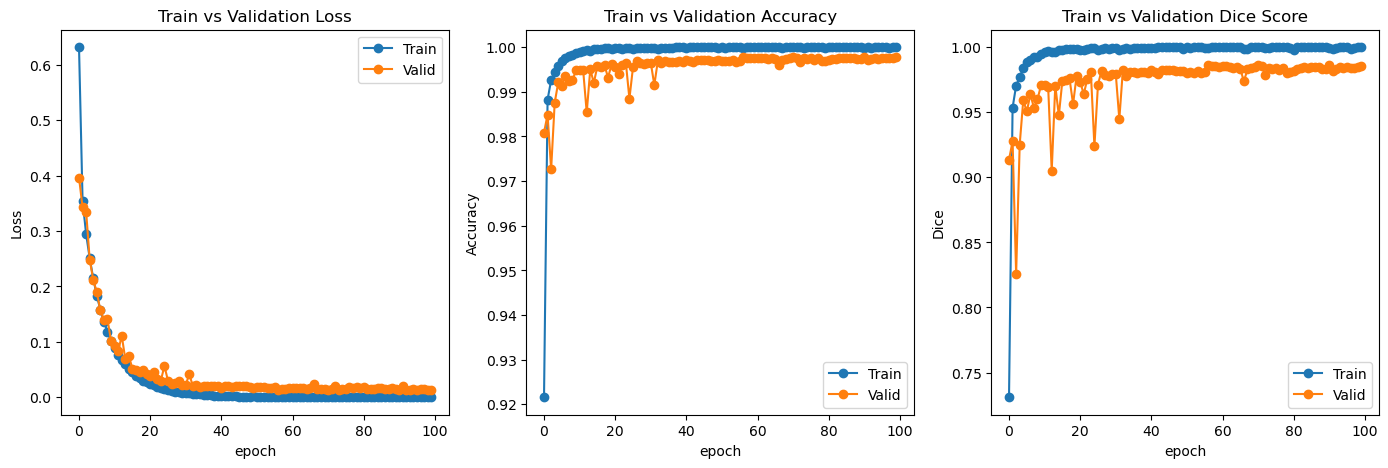

In [19]:
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

## Comments
Accuracy can be misleading for segmentation tasks. A quite large class imbalance is often present and by always (or almost always) predicting the majority class or classes a high accuracy can be achieved. In real life applications the smaller classes can also be the most important ones to detect. For a self-driving car, the road, surrounding bildings or trees might be the majority classes - but a pedestrian is more impartant to detect. In a medical context normal tissue could be the majority class while a tumor is the minority class but the most important thing to detect.

There are several articles and blog posts on alternative metrics for image segmentation tasks available - here is one of many examples: [Understanding Evaluation Metrics in Medical Image Segmentation](https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f)  
Alternative metrics include Dice coefficient and Jaccard index. In this project the Dice score, which is often mentioned, is used. This is basically the F1 score for computer vision and the [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) implementation is used.

## Augmentation
The albumentations documentation had some interesting examples and guides for implementing augmentation on input images and masks. The most important lesson is to (in most cases) aplly the same augmentation to the input and the ground truth. This can be done in several ways depending on the shape of the masks but here *additional_targets* is used and the transformation are applied to the input images and the ground truth images.

In [16]:
def save_predictions_as_imgs(loader, model, folder="output_images/", device="cuda:0"):
    model.eval()
    for idx, (x, y, z) in enumerate(loader):
        imsave(f"{folder}/{idx}_input.jpg" , x.numpy().astype(np.uint8))
        imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
        x = x.permute(0,3,1,2)
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.argmax(model(x), dim=1).squeeze().long()
            imgs = class_to_rgb(preds.cpu())
        imsave(f"{folder}/{idx}_pred.jpg" , imgs)
    model.train()

In [21]:
# save output to a folder
my_path = 'output_images/01/val'
if path.exists(my_path) == False:
  os.mkdir(my_path)
my_loader = DataLoader(Objects(validation_img_dir,transform=val_transform), batch_size=1)
save_predictions_as_imgs(my_loader, best_model, folder=my_path, device="cuda:0")

C:\Users\-\AppData\Local\Temp\ipykernel_26456\3577722451.py:5: UserWarning: output_images/01/val/1252_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_26456\3577722451.py:5: UserWarning: output_images/01/val/1253_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_26456\3577722451.py:5: UserWarning: output_images/01/val/1254_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_26456\3577722451.py:5: UserWarning: output_images/01/val/1255_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_26456\3577722451.py:5: UserWarning: output_images/01/val/1256_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uin

In [22]:
# save model state_dict
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

best_model_state = deepcopy(best_model.state_dict())
torch.save(best_model_state, 'model/01/best_model.pth')

# load
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH, weights_only=True))
#model.eval()

In [15]:
# https://albumentations.ai/docs/examples/example_multi_target/

train_transform_alb = A.Compose(
    [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
     ],
    additional_targets={'image0':'image', 'image1':'image'}
)

In [16]:
train_transform = train_transform_alb

batch_size = 32
train_loader_2 = DataLoader(Objects(training_img_dir,transform=train_transform), batch_size=batch_size, shuffle=True)
print("Number of images in training set: ", len(train_loader_2)*batch_size)
print("Number of batches per epoch: ", len(train_loader_2))

Number of images in training set:  10848
Number of batches per epoch:  339


In [17]:
val_transform = None

batch_size = 32
val_loader_2 = DataLoader(Objects(validation_img_dir,transform=val_transform), batch_size=batch_size)
print("Number of images in validation set: ", len(val_loader_2)*batch_size)
print("Number of batches per epoch: ", len(val_loader_2))

Number of images in validation set:  2272
Number of batches per epoch:  71


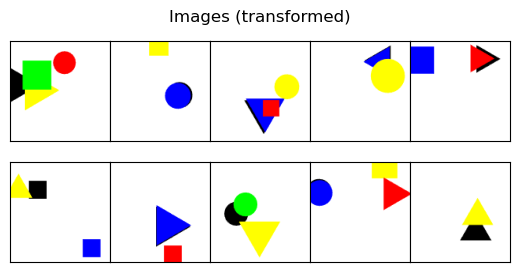

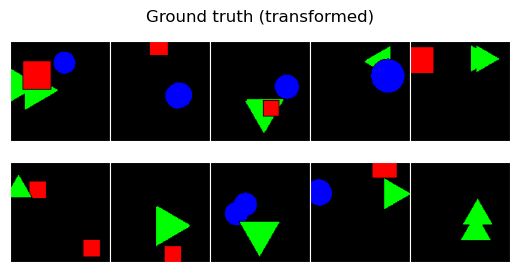

In [18]:
images, gt_class, gt_img = next(iter(train_loader_2))
show_images(images, title='Images (transformed)')
show_images(gt_img, title='Ground truth (transformed)', ax_color='white')

In [20]:
num_channels = 3
num_classes = 4
# instantiate model
my_model_2 = UnetModel(num_channels, num_classes)
# instantiate loss
# https://discuss.pytorch.org/t/nllloss-vs-crossentropyloss/92777
critereon = nn.CrossEntropyLoss()
#critereon = nn.NLLLoss()

# instantiate a suitable optimizer
my_lr = 1e-5 # learning rate
optimizer = torch.optim.Adam(my_model_2.parameters(), lr=my_lr)

best_model_2, train_losses, train_accuracies, train_dices, val_losses, val_accuracies, val_dices = a_proper_training(
    100, my_model_2, optimizer, critereon, train_loader_2, val_loader_2
)

  0%|          | 0/100 [00:00<?, ?it/s]

Training device: cuda:0
Validation device: cuda:0


  1%|          | 1/100 [02:45<4:32:34, 165.20s/it]

Epoch 1/100: Train Loss = 0.7108231640495031, Train Accuracy = 0.8839448807342465, Train Dice = 0.6075366735458374, Val Loss = 0.4800390282147367, Val Accuracy = 0.9691927704306811, Val Dice = 0.8447866439819336


  2%|▏         | 2/100 [05:23<4:22:58, 161.00s/it]

Epoch 2/100: Train Loss = 0.41367466224681665, Train Accuracy = 0.9832673109403167, Train Dice = 0.9279524683952332, Val Loss = 0.36937135709843166, Val Accuracy = 0.9851641265583166, Val Dice = 0.9318451881408691


  3%|▎         | 3/100 [08:00<4:17:34, 159.33s/it]

Epoch 3/100: Train Loss = 0.3443436131189003, Train Accuracy = 0.9887773404999075, Train Dice = 0.9525116682052612, Val Loss = 0.3103156471756143, Val Accuracy = 0.9895877455133032, Val Dice = 0.9464850425720215


  4%|▍         | 4/100 [10:37<4:13:17, 158.31s/it]

Epoch 4/100: Train Loss = 0.2939777702181037, Train Accuracy = 0.9922518698865213, Train Dice = 0.9663801789283752, Val Loss = 0.27737030219024333, Val Accuracy = 0.9906199232694668, Val Dice = 0.9496400952339172


  5%|▌         | 5/100 [13:24<4:15:45, 161.53s/it]

Epoch 5/100: Train Loss = 0.25202206071675, Train Accuracy = 0.9938448440172298, Train Dice = 0.9733493328094482, Val Loss = 0.21971668911651826, Val Accuracy = 0.9935037731220019, Val Dice = 0.9646943807601929


  6%|▌         | 6/100 [16:57<4:40:20, 178.94s/it]

Epoch 6/100: Train Loss = 0.2170809876602308, Train Accuracy = 0.995184480212715, Train Dice = 0.9796474575996399, Val Loss = 0.20793449962642832, Val Accuracy = 0.9937151764610526, Val Dice = 0.9677783846855164


  7%|▋         | 7/100 [20:28<4:53:33, 189.39s/it]

Epoch 7/100: Train Loss = 0.18716732344444523, Train Accuracy = 0.9961102318056213, Train Dice = 0.9837723970413208, Val Loss = 0.19121699979607487, Val Accuracy = 0.9893556158226656, Val Dice = 0.9340234398841858


  8%|▊         | 8/100 [23:30<4:46:57, 187.14s/it]

Epoch 8/100: Train Loss = 0.16353061808421548, Train Accuracy = 0.9964999156330169, Train Dice = 0.9842105507850647, Val Loss = 0.16760494402596648, Val Accuracy = 0.994573372700873, Val Dice = 0.9732683300971985


  9%|▉         | 9/100 [26:59<4:54:14, 194.00s/it]

Epoch 9/100: Train Loss = 0.14112766392550988, Train Accuracy = 0.9971743211008279, Train Dice = 0.98805171251297, Val Loss = 0.1334241736732738, Val Accuracy = 0.9925433886152248, Val Dice = 0.9515814781188965


 10%|█         | 10/100 [30:31<4:59:19, 199.55s/it]

Epoch 10/100: Train Loss = 0.1243281670596044, Train Accuracy = 0.9973578554012204, Train Dice = 0.9871665239334106, Val Loss = 0.14970798863911292, Val Accuracy = 0.9875123867867303, Val Dice = 0.9212274551391602


 11%|█         | 11/100 [34:04<5:02:14, 203.76s/it]

Epoch 11/100: Train Loss = 0.10875062077446321, Train Accuracy = 0.9974884064236994, Train Dice = 0.9881407022476196, Val Loss = 0.10799718637701491, Val Accuracy = 0.9946073083566906, Val Dice = 0.9684222340583801


 12%|█▏        | 12/100 [37:31<4:59:57, 204.52s/it]

Epoch 12/100: Train Loss = 0.09438024074454575, Train Accuracy = 0.9979504160930855, Train Dice = 0.9914354681968689, Val Loss = 0.0918996586975917, Val Accuracy = 0.9963689392988622, Val Dice = 0.9783701300621033


 13%|█▎        | 13/100 [41:05<5:00:40, 207.37s/it]

Epoch 13/100: Train Loss = 0.08243126347441238, Train Accuracy = 0.9982390536434981, Train Dice = 0.9928950667381287, Val Loss = 0.08252702170694379, Val Accuracy = 0.9967316913051512, Val Dice = 0.9809732437133789


 14%|█▍        | 14/100 [43:58<4:42:36, 197.17s/it]

Epoch 14/100: Train Loss = 0.07214640817195617, Train Accuracy = 0.9984203986455059, Train Dice = 0.9937124848365784, Val Loss = 0.07311083019619256, Val Accuracy = 0.9964456622061161, Val Dice = 0.9773311018943787


 15%|█▌        | 15/100 [47:24<4:42:56, 199.72s/it]

Epoch 15/100: Train Loss = 0.06358645453082074, Train Accuracy = 0.9984958899421195, Train Dice = 0.9939120411872864, Val Loss = 0.06288563334186312, Val Accuracy = 0.9966841922812779, Val Dice = 0.9794611930847168


 16%|█▌        | 16/100 [50:55<4:44:16, 203.06s/it]

Epoch 16/100: Train Loss = 0.05619096732904426, Train Accuracy = 0.9986005135778029, Train Dice = 0.9942563772201538, Val Loss = 0.07129803877061522, Val Accuracy = 0.9932682389715111, Val Dice = 0.9536633491516113


 17%|█▋        | 17/100 [54:21<4:42:17, 204.07s/it]

Epoch 17/100: Train Loss = 0.04990621406727836, Train Accuracy = 0.99851310527555, Train Dice = 0.9935885071754456, Val Loss = 0.04684554187344833, Val Accuracy = 0.9971195546073182, Val Dice = 0.9833741188049316


 18%|█▊        | 18/100 [57:52<4:41:32, 206.01s/it]

Epoch 18/100: Train Loss = 0.04357195560955017, Train Accuracy = 0.9988055063878761, Train Dice = 0.9952038526535034, Val Loss = 0.049325178154337575, Val Accuracy = 0.9969871892082218, Val Dice = 0.9816268682479858


 19%|█▉        | 19/100 [1:01:25<4:41:15, 208.34s/it]

Epoch 19/100: Train Loss = 0.03823078303957759, Train Accuracy = 0.9989205461184507, Train Dice = 0.9958357214927673, Val Loss = 0.04236514383638409, Val Accuracy = 0.9970830043263331, Val Dice = 0.9823324680328369


 20%|██        | 20/100 [1:04:59<4:40:01, 210.02s/it]

Epoch 20/100: Train Loss = 0.0339160237549241, Train Accuracy = 0.9989833981666589, Train Dice = 0.9957159161567688, Val Loss = 0.03454953447823793, Val Accuracy = 0.997071892169372, Val Dice = 0.9816445112228394


 21%|██        | 21/100 [1:08:30<4:36:58, 210.36s/it]

Epoch 21/100: Train Loss = 0.031761737864541444, Train Accuracy = 0.9985252479820537, Train Dice = 0.9930206537246704, Val Loss = 0.03450139845445962, Val Accuracy = 0.9975241950876422, Val Dice = 0.9849869608879089


 22%|██▏       | 22/100 [1:12:00<4:33:12, 210.16s/it]

Epoch 22/100: Train Loss = 0.02673105686727175, Train Accuracy = 0.9990174282144859, Train Dice = 0.9961406588554382, Val Loss = 0.02881095550534591, Val Accuracy = 0.9974866370865406, Val Dice = 0.9848848581314087


 23%|██▎       | 23/100 [1:15:30<4:29:24, 209.93s/it]

Epoch 23/100: Train Loss = 0.024389685980514088, Train Accuracy = 0.9991054233389861, Train Dice = 0.9947134256362915, Val Loss = 0.04093482980216053, Val Accuracy = 0.9948650123497462, Val Dice = 0.9728965163230896


 24%|██▍       | 24/100 [1:19:02<4:26:59, 210.79s/it]

Epoch 24/100: Train Loss = 0.021937603218849078, Train Accuracy = 0.9989050122564598, Train Dice = 0.9953688979148865, Val Loss = 0.021823252013451616, Val Accuracy = 0.997830977773943, Val Dice = 0.9871570467948914


 25%|██▌       | 25/100 [1:22:37<4:25:01, 212.02s/it]

Epoch 25/100: Train Loss = 0.018788924498434088, Train Accuracy = 0.999181213689245, Train Dice = 0.9968333840370178, Val Loss = 0.021777516978622322, Val Accuracy = 0.9978175505842816, Val Dice = 0.9871454238891602


 26%|██▌       | 26/100 [1:25:59<4:17:31, 208.80s/it]

Epoch 26/100: Train Loss = 0.016747955095495447, Train Accuracy = 0.9992410244183056, Train Dice = 0.9970898628234863, Val Loss = 0.020288025999677852, Val Accuracy = 0.9980723403597027, Val Dice = 0.9885141849517822


 27%|██▋       | 27/100 [1:28:35<3:55:03, 193.20s/it]

Epoch 27/100: Train Loss = 0.014860069480859248, Train Accuracy = 0.9993065397367136, Train Dice = 0.9973431825637817, Val Loss = 0.01935736673661101, Val Accuracy = 0.9977986762588549, Val Dice = 0.986765444278717


 28%|██▊       | 28/100 [1:31:10<3:38:04, 181.73s/it]

Epoch 28/100: Train Loss = 0.013284774475173261, Train Accuracy = 0.999342341536326, Train Dice = 0.9974957704544067, Val Loss = 0.017045275150785143, Val Accuracy = 0.9979385042339497, Val Dice = 0.987410306930542


 29%|██▉       | 29/100 [1:33:45<3:25:33, 173.71s/it]

Epoch 29/100: Train Loss = 0.01185767878956851, Train Accuracy = 0.9994055659909604, Train Dice = 0.997698962688446, Val Loss = 0.017645700532995478, Val Accuracy = 0.9976223524741327, Val Dice = 0.9858298301696777


 30%|███       | 30/100 [1:36:19<3:15:43, 167.77s/it]

Epoch 30/100: Train Loss = 0.010773585232903296, Train Accuracy = 0.9994375083057918, Train Dice = 0.997253954410553, Val Loss = 0.020462267992781922, Val Accuracy = 0.9967076422007475, Val Dice = 0.9787560701370239


 31%|███       | 31/100 [1:38:53<3:08:11, 163.64s/it]

Epoch 31/100: Train Loss = 0.011125492298794268, Train Accuracy = 0.9991067493315643, Train Dice = 0.993994951248169, Val Loss = 0.017428476337186048, Val Accuracy = 0.9975105500125502, Val Dice = 0.9840994477272034


 32%|███▏      | 32/100 [1:41:29<3:02:42, 161.22s/it]

Epoch 32/100: Train Loss = 0.009493048158597894, Train Accuracy = 0.999215791061668, Train Dice = 0.9965305328369141, Val Loss = 0.012865807861089706, Val Accuracy = 0.9982113240287539, Val Dice = 0.9892551898956299


 33%|███▎      | 33/100 [1:44:03<2:57:40, 159.12s/it]

Epoch 33/100: Train Loss = 0.007822558182157071, Train Accuracy = 0.9994835230695173, Train Dice = 0.998016357421875, Val Loss = 0.010962046505752164, Val Accuracy = 0.9984101444841867, Val Dice = 0.9906029105186462


 34%|███▍      | 34/100 [1:46:37<2:53:14, 157.49s/it]

Epoch 34/100: Train Loss = 0.007087186219275086, Train Accuracy = 0.9995170452903994, Train Dice = 0.998117208480835, Val Loss = 0.01091490600677863, Val Accuracy = 0.9983293634607876, Val Dice = 0.9903551340103149


 35%|███▌      | 35/100 [1:49:10<2:49:25, 156.39s/it]

Epoch 35/100: Train Loss = 0.006365058079614664, Train Accuracy = 0.9995752422582798, Train Dice = 0.9983099102973938, Val Loss = 0.010466031684264751, Val Accuracy = 0.9984243615085341, Val Dice = 0.9904687404632568


 36%|███▌      | 36/100 [1:51:44<2:46:00, 155.63s/it]

Epoch 36/100: Train Loss = 0.00574079205922145, Train Accuracy = 0.9995943647640144, Train Dice = 0.9984217286109924, Val Loss = 0.009312368207939074, Val Accuracy = 0.9984836808170181, Val Dice = 0.9910165071487427


 37%|███▋      | 37/100 [1:54:18<2:42:47, 155.03s/it]

Epoch 37/100: Train Loss = 0.005338738609935023, Train Accuracy = 0.9996314248459456, Train Dice = 0.998113214969635, Val Loss = 0.013331985625792558, Val Accuracy = 0.9973228689497574, Val Dice = 0.9841110706329346


 38%|███▊      | 38/100 [1:56:53<2:40:08, 154.98s/it]

Epoch 38/100: Train Loss = 0.005791881129936834, Train Accuracy = 0.9992923657224305, Train Dice = 0.9966233372688293, Val Loss = 0.008675979351965894, Val Accuracy = 0.9983652056141231, Val Dice = 0.9895739555358887


 39%|███▉      | 39/100 [1:59:27<2:37:23, 154.81s/it]

Epoch 39/100: Train Loss = 0.004315010368807521, Train Accuracy = 0.999633715709719, Train Dice = 0.9985817074775696, Val Loss = 0.007643311789495425, Val Accuracy = 0.9985964092916806, Val Dice = 0.991392970085144


 40%|████      | 40/100 [2:02:01<2:34:31, 154.53s/it]

Epoch 40/100: Train Loss = 0.003876723137555045, Train Accuracy = 0.999666431050011, Train Dice = 0.998679518699646, Val Loss = 0.007625369325568768, Val Accuracy = 0.9985697183264307, Val Dice = 0.9913010597229004


 41%|████      | 41/100 [2:04:35<2:31:48, 154.38s/it]

Epoch 41/100: Train Loss = 0.0034209389196967043, Train Accuracy = 0.9997162996559957, Train Dice = 0.9989093542098999, Val Loss = 0.0065961152242995065, Val Accuracy = 0.9987635546526383, Val Dice = 0.9925521612167358


 42%|████▏     | 42/100 [2:07:09<2:29:09, 154.30s/it]

Epoch 42/100: Train Loss = 0.003054259553040683, Train Accuracy = 0.9997426050917393, Train Dice = 0.9990137815475464, Val Loss = 0.006440938637316437, Val Accuracy = 0.9987605587279674, Val Dice = 0.9925811886787415


 43%|████▎     | 43/100 [2:09:43<2:26:29, 154.20s/it]

Epoch 43/100: Train Loss = 0.0033707217496042317, Train Accuracy = 0.9997663375376289, Train Dice = 0.998134434223175, Val Loss = 0.020416943651532203, Val Accuracy = 0.9954324677180946, Val Dice = 0.9685595631599426


 44%|████▍     | 44/100 [2:12:17<2:23:45, 154.03s/it]

Epoch 44/100: Train Loss = 0.004013668583667559, Train Accuracy = 0.9994413282929214, Train Dice = 0.9958603382110596, Val Loss = 0.010270429276664493, Val Accuracy = 0.9979565342533327, Val Dice = 0.9864839315414429


 45%|████▌     | 45/100 [2:14:51<2:21:08, 153.97s/it]

Epoch 45/100: Train Loss = 0.002962185313051517, Train Accuracy = 0.9995989972742558, Train Dice = 0.9981408715248108, Val Loss = 0.005770774971378941, Val Accuracy = 0.9986642261319584, Val Dice = 0.9917387366294861


 46%|████▌     | 46/100 [2:17:25<2:18:43, 154.14s/it]

Epoch 46/100: Train Loss = 0.0025341149198391355, Train Accuracy = 0.9996857341164371, Train Dice = 0.9985697269439697, Val Loss = 0.007085963601613759, Val Accuracy = 0.9984215834692939, Val Dice = 0.9909756779670715


 47%|████▋     | 47/100 [2:20:44<2:28:00, 167.56s/it]

Epoch 47/100: Train Loss = 0.0021992187094009292, Train Accuracy = 0.9997508657433756, Train Dice = 0.9990050792694092, Val Loss = 0.004962775762796297, Val Accuracy = 0.9989711177609745, Val Dice = 0.9940527081489563


 48%|████▊     | 48/100 [2:24:15<2:36:26, 180.50s/it]

Epoch 48/100: Train Loss = 0.002361243907678158, Train Accuracy = 0.9997582066639895, Train Dice = 0.9972250461578369, Val Loss = 0.005660328835340768, Val Accuracy = 0.998811925218234, Val Dice = 0.9928545951843262


 49%|████▉     | 49/100 [2:27:48<2:41:40, 190.20s/it]

Epoch 49/100: Train Loss = 0.0019325309173426532, Train Accuracy = 0.9997629125270119, Train Dice = 0.9990373253822327, Val Loss = 0.005167489650029637, Val Accuracy = 0.998922229717481, Val Dice = 0.9933739900588989


 50%|█████     | 50/100 [2:31:21<2:44:16, 197.12s/it]

Epoch 50/100: Train Loss = 0.0016396279243483128, Train Accuracy = 0.9998121604556196, Train Dice = 0.9992728233337402, Val Loss = 0.004879962470920258, Val Accuracy = 0.9990116989224258, Val Dice = 0.9940863251686096


 51%|█████     | 51/100 [2:34:54<2:44:47, 201.79s/it]

Epoch 51/100: Train Loss = 0.001711532852686612, Train Accuracy = 0.9998255388743558, Train Dice = 0.9983041286468506, Val Loss = 0.007349592581076521, Val Accuracy = 0.9983375341644355, Val Dice = 0.9896976351737976


 52%|█████▏    | 52/100 [2:38:25<2:43:49, 204.79s/it]

Epoch 52/100: Train Loss = 0.0021958151718211474, Train Accuracy = 0.9996122064173436, Train Dice = 0.9979260563850403, Val Loss = 0.010447175830641997, Val Accuracy = 0.997724595212447, Val Dice = 0.9845914840698242


 53%|█████▎    | 53/100 [2:41:05<2:29:47, 191.21s/it]

Epoch 53/100: Train Loss = 0.001982225408052317, Train Accuracy = 0.999644944327722, Train Dice = 0.9982815384864807, Val Loss = 0.004062616959063362, Val Accuracy = 0.99905059147179, Val Dice = 0.9943791627883911


 54%|█████▍    | 54/100 [2:43:39<2:18:09, 180.20s/it]

Epoch 54/100: Train Loss = 0.0013180596121740707, Train Accuracy = 0.9998167591107314, Train Dice = 0.9992767572402954, Val Loss = 0.004004141604396659, Val Accuracy = 0.9990613223292475, Val Dice = 0.9946393370628357


 55%|█████▌    | 55/100 [2:46:13<2:09:15, 172.34s/it]

Epoch 55/100: Train Loss = 0.0012468335105059532, Train Accuracy = 0.9998165277673454, Train Dice = 0.9992843866348267, Val Loss = 0.003932165779652152, Val Accuracy = 0.9991521533181337, Val Dice = 0.9950324892997742


 56%|█████▌    | 56/100 [2:48:48<2:02:28, 167.02s/it]

Epoch 56/100: Train Loss = 0.001116986963231732, Train Accuracy = 0.9998488199185166, Train Dice = 0.9993986487388611, Val Loss = 0.004358838254120201, Val Accuracy = 0.9989889026592481, Val Dice = 0.9936009645462036


 57%|█████▋    | 57/100 [2:51:23<1:57:08, 163.46s/it]

Epoch 57/100: Train Loss = 0.0010628983700183663, Train Accuracy = 0.9998369875507015, Train Dice = 0.9993739724159241, Val Loss = 0.004167341447638636, Val Accuracy = 0.9991215948864904, Val Dice = 0.9947059154510498


 58%|█████▊    | 58/100 [2:53:58<1:52:31, 160.76s/it]

Epoch 58/100: Train Loss = 0.0009243136806177266, Train Accuracy = 0.9998678013612109, Train Dice = 0.9994869828224182, Val Loss = 0.004554571981482785, Val Accuracy = 0.9990329155162316, Val Dice = 0.9940639734268188


 59%|█████▉    | 59/100 [2:56:32<1:48:31, 158.83s/it]

Epoch 59/100: Train Loss = 0.0008497969249117801, Train Accuracy = 0.9998743636138427, Train Dice = 0.9995163679122925, Val Loss = 0.003849566105792535, Val Accuracy = 0.9991768016074716, Val Dice = 0.9950896501541138


 60%|██████    | 60/100 [2:59:24<1:48:27, 162.69s/it]

Epoch 60/100: Train Loss = 0.0008065223995703314, Train Accuracy = 0.9998844919401318, Train Dice = 0.9995251893997192, Val Loss = 0.0040854563191369125, Val Accuracy = 0.9991015221911953, Val Dice = 0.994379460811615


 61%|██████    | 61/100 [3:02:53<1:54:55, 176.81s/it]

Epoch 61/100: Train Loss = 0.00182719000994302, Train Accuracy = 0.9995407664512457, Train Dice = 0.9974904656410217, Val Loss = 0.004140090147725267, Val Accuracy = 0.9989352211362812, Val Dice = 0.9933261871337891


 62%|██████▏   | 62/100 [3:06:25<1:58:33, 187.20s/it]

Epoch 62/100: Train Loss = 0.0007772694810933727, Train Accuracy = 0.9998644553458965, Train Dice = 0.999462366104126, Val Loss = 0.004371668338778914, Val Accuracy = 0.9989933148392179, Val Dice = 0.9935985803604126


 63%|██████▎   | 63/100 [3:09:57<2:00:00, 194.62s/it]

Epoch 63/100: Train Loss = 0.0006856844117617713, Train Accuracy = 0.9998836173492823, Train Dice = 0.9995443224906921, Val Loss = 0.004202118208615477, Val Accuracy = 0.9990421211756749, Val Dice = 0.99396812915802


 64%|██████▍   | 64/100 [3:13:27<1:59:37, 199.38s/it]

Epoch 64/100: Train Loss = 0.000630250469346017, Train Accuracy = 0.9998937400330499, Train Dice = 0.9995757341384888, Val Loss = 0.004129018819838447, Val Accuracy = 0.9989942953236557, Val Dice = 0.9938835501670837


 65%|██████▌   | 65/100 [3:16:56<1:57:56, 202.17s/it]

Epoch 65/100: Train Loss = 0.0007324808778222046, Train Accuracy = 0.9998659731842094, Train Dice = 0.9994081854820251, Val Loss = 0.005560798543869374, Val Accuracy = 0.9986533590961066, Val Dice = 0.9911103248596191


 66%|██████▌   | 66/100 [3:20:28<1:56:10, 205.00s/it]

Epoch 66/100: Train Loss = 0.001377060388267771, Train Accuracy = 0.9996602524888486, Train Dice = 0.9981649518013, Val Loss = 0.004723382100026766, Val Accuracy = 0.9988829013972557, Val Dice = 0.9926649332046509


 67%|██████▋   | 67/100 [3:23:58<1:53:43, 206.77s/it]

Epoch 67/100: Train Loss = 0.0006113623990574275, Train Accuracy = 0.999875458263035, Train Dice = 0.9995044469833374, Val Loss = 0.005140088890469305, Val Accuracy = 0.9988273950838075, Val Dice = 0.992168128490448


 68%|██████▊   | 68/100 [3:27:29<1:50:56, 208.00s/it]

Epoch 68/100: Train Loss = 0.0005407855537950795, Train Accuracy = 0.9998912686085849, Train Dice = 0.9995703101158142, Val Loss = 0.004341602260673183, Val Accuracy = 0.9989847083647089, Val Dice = 0.9932495951652527


 69%|██████▉   | 69/100 [3:30:56<1:47:14, 207.55s/it]

Epoch 69/100: Train Loss = 0.00048158054805297546, Train Accuracy = 0.9999063284987606, Train Dice = 0.9996370077133179, Val Loss = 0.004582871630473036, Val Accuracy = 0.99896820354334, Val Dice = 0.9931195378303528


 70%|███████   | 70/100 [3:34:30<1:44:46, 209.56s/it]

Epoch 70/100: Train Loss = 0.0010640515839738722, Train Accuracy = 0.9999065485571034, Train Dice = 0.9980856776237488, Val Loss = 0.004947357095120488, Val Accuracy = 0.9987982529074632, Val Dice = 0.9919965267181396


 71%|███████   | 71/100 [3:38:06<1:42:11, 211.42s/it]

Epoch 71/100: Train Loss = 0.0013412892481739355, Train Accuracy = 0.9996667131760915, Train Dice = 0.9982495903968811, Val Loss = 0.004955599941214888, Val Accuracy = 0.9987606949063615, Val Dice = 0.9918844699859619


 72%|███████▏  | 72/100 [3:41:40<1:39:01, 212.20s/it]

Epoch 72/100: Train Loss = 0.000533272556814291, Train Accuracy = 0.9998827935411274, Train Dice = 0.9995233416557312, Val Loss = 0.004317571808711927, Val Accuracy = 0.9989358747925731, Val Dice = 0.9930924773216248


 73%|███████▎  | 73/100 [3:45:12<1:35:31, 212.29s/it]

Epoch 73/100: Train Loss = 0.00045950296889526283, Train Accuracy = 0.9998996138980453, Train Dice = 0.9996016621589661, Val Loss = 0.004288226176868193, Val Accuracy = 0.9989727519017041, Val Dice = 0.9934042096138


 74%|███████▍  | 74/100 [3:48:47<1:32:15, 212.89s/it]

Epoch 74/100: Train Loss = 0.00042444659106139436, Train Accuracy = 0.9999088394208768, Train Dice = 0.9996369481086731, Val Loss = 0.003954656702108865, Val Accuracy = 0.9990406232133394, Val Dice = 0.9937337636947632


 75%|███████▌  | 75/100 [3:52:19<1:28:41, 212.87s/it]

Epoch 75/100: Train Loss = 0.00041955683070783034, Train Accuracy = 0.999914487585008, Train Dice = 0.9996582865715027, Val Loss = 0.005377441880573571, Val Accuracy = 0.9988926790059544, Val Dice = 0.9931057095527649


 76%|███████▌  | 76/100 [3:55:53<1:25:13, 213.08s/it]

Epoch 76/100: Train Loss = 0.0006634190916063148, Train Accuracy = 0.9998392671294317, Train Dice = 0.9992794394493103, Val Loss = 0.014121789237833582, Val Accuracy = 0.9970156504925953, Val Dice = 0.9788122773170471


 77%|███████▋  | 77/100 [3:59:27<1:21:47, 213.37s/it]

Epoch 77/100: Train Loss = 0.0007698589932121293, Train Accuracy = 0.9998070934712143, Train Dice = 0.9989901185035706, Val Loss = 0.004430179638930754, Val Accuracy = 0.9989037911629155, Val Dice = 0.992933988571167


 78%|███████▊  | 78/100 [4:02:59<1:18:07, 213.06s/it]

Epoch 78/100: Train Loss = 0.0005855855734944673, Train Accuracy = 0.9998514719036731, Train Dice = 0.9993827939033508, Val Loss = 0.0032632978221903306, Val Accuracy = 0.9991893027840528, Val Dice = 0.9949488043785095


 79%|███████▉  | 79/100 [4:06:31<1:14:24, 212.60s/it]

Epoch 79/100: Train Loss = 0.000376548501834614, Train Accuracy = 0.9999134380759886, Train Dice = 0.9996613264083862, Val Loss = 0.003803149783290254, Val Accuracy = 0.9990878498804244, Val Dice = 0.9941021203994751


 80%|████████  | 80/100 [4:10:03<1:10:46, 212.32s/it]

Epoch 80/100: Train Loss = 0.00033498835569806674, Train Accuracy = 0.9999240065189632, Train Dice = 0.9997064471244812, Val Loss = 0.003364719316534678, Val Accuracy = 0.9991973373093067, Val Dice = 0.9949204325675964


 81%|████████  | 81/100 [4:13:34<1:07:09, 212.10s/it]

Epoch 81/100: Train Loss = 0.00031434071027388065, Train Accuracy = 0.9999289606529363, Train Dice = 0.9997267127037048, Val Loss = 0.0033345572889411927, Val Accuracy = 0.999202621030999, Val Dice = 0.9949433207511902


 82%|████████▏ | 82/100 [4:17:04<1:03:22, 211.26s/it]

Epoch 82/100: Train Loss = 0.00030515606872769, Train Accuracy = 0.9999328427078037, Train Dice = 0.9997309446334839, Val Loss = 0.0038015061284785985, Val Accuracy = 0.9991182721336735, Val Dice = 0.99443119764328


 83%|████████▎ | 83/100 [4:20:36<59:58, 211.66s/it]  

Epoch 83/100: Train Loss = 0.00032093647312322096, Train Accuracy = 0.999930281002993, Train Dice = 0.9997128248214722, Val Loss = 0.0034652482169970516, Val Accuracy = 0.999188349535294, Val Dice = 0.9950676560401917


 84%|████████▍ | 84/100 [4:24:07<56:22, 211.38s/it]

Epoch 84/100: Train Loss = 0.0005332360855079802, Train Accuracy = 0.9999198084828858, Train Dice = 0.9982271790504456, Val Loss = 0.00491821378470287, Val Accuracy = 0.9988241540380272, Val Dice = 0.9925169348716736


 85%|████████▌ | 85/100 [4:27:39<52:55, 211.67s/it]

Epoch 85/100: Train Loss = 0.0008557809849120649, Train Accuracy = 0.9997679343712443, Train Dice = 0.9988389611244202, Val Loss = 0.004467957737547359, Val Accuracy = 0.9989117167454541, Val Dice = 0.9925717711448669


 86%|████████▌ | 86/100 [4:31:12<49:27, 211.93s/it]

Epoch 86/100: Train Loss = 0.0007626384999867457, Train Accuracy = 0.9999170718599051, Train Dice = 0.9988433718681335, Val Loss = 0.006812964748463292, Val Accuracy = 0.9985082201636407, Val Dice = 0.989787220954895


 87%|████████▋ | 87/100 [4:34:42<45:50, 211.58s/it]

Epoch 87/100: Train Loss = 0.001376140029252037, Train Accuracy = 0.9996444590708635, Train Dice = 0.9980049133300781, Val Loss = 0.0035168486188205195, Val Accuracy = 0.9990641820755243, Val Dice = 0.9940140247344971


 88%|████████▊ | 88/100 [4:38:14<42:20, 211.67s/it]

Epoch 88/100: Train Loss = 0.00046448809404481083, Train Accuracy = 0.9998796393715477, Train Dice = 0.9994805455207825, Val Loss = 0.003260782011251726, Val Accuracy = 0.9991542232297245, Val Dice = 0.9946991801261902


 89%|████████▉ | 89/100 [4:41:46<38:47, 211.55s/it]

Epoch 89/100: Train Loss = 0.0003515261413074843, Train Accuracy = 0.9999123772819261, Train Dice = 0.9996470808982849, Val Loss = 0.003100957083749473, Val Accuracy = 0.9991924076514391, Val Dice = 0.9949067831039429


 90%|█████████ | 90/100 [4:45:17<35:16, 211.63s/it]

Epoch 90/100: Train Loss = 0.0003116897330172964, Train Accuracy = 0.9999226410287337, Train Dice = 0.9996930956840515, Val Loss = 0.0033795720234375552, Val Accuracy = 0.9991826572784193, Val Dice = 0.9950260519981384


 91%|█████████ | 91/100 [4:48:49<31:43, 211.55s/it]

Epoch 91/100: Train Loss = 0.000599540409174951, Train Accuracy = 0.9999241193693954, Train Dice = 0.998247504234314, Val Loss = 0.004622279603852445, Val Accuracy = 0.9990776092651857, Val Dice = 0.994178295135498


 92%|█████████▏| 92/100 [4:52:18<28:06, 210.76s/it]

Epoch 92/100: Train Loss = 0.0008696076428159869, Train Accuracy = 0.9997647689166214, Train Dice = 0.9987576007843018, Val Loss = 0.003867428726947073, Val Accuracy = 0.9990513268351182, Val Dice = 0.9936292171478271


 93%|█████████▎| 93/100 [4:55:49<24:35, 210.84s/it]

Epoch 93/100: Train Loss = 0.000354301358695392, Train Accuracy = 0.999908766068096, Train Dice = 0.9996219873428345, Val Loss = 0.0038325101627827243, Val Accuracy = 0.9990876864663515, Val Dice = 0.9938246011734009


 94%|█████████▍| 94/100 [4:59:18<21:03, 210.51s/it]

Epoch 94/100: Train Loss = 0.0002973324179757183, Train Accuracy = 0.999924875467291, Train Dice = 0.9997024536132812, Val Loss = 0.003448224074840972, Val Accuracy = 0.999159779308205, Val Dice = 0.9943081140518188


 95%|█████████▌| 95/100 [5:02:49<17:32, 210.44s/it]

Epoch 95/100: Train Loss = 0.000292711677677053, Train Accuracy = 0.9999323123107724, Train Dice = 0.9997257590293884, Val Loss = 0.003713497069019096, Val Accuracy = 0.9990512451280817, Val Dice = 0.9938023090362549


 96%|█████████▌| 96/100 [5:06:18<14:00, 210.13s/it]

Epoch 96/100: Train Loss = 0.00046301795854209165, Train Accuracy = 0.9998908510619857, Train Dice = 0.9994595646858215, Val Loss = 0.003583700157551121, Val Accuracy = 0.9990790527561635, Val Dice = 0.9943239092826843


 97%|█████████▋| 97/100 [5:09:49<10:30, 210.22s/it]

Epoch 97/100: Train Loss = 0.0009283020021926177, Train Accuracy = 0.9998882555020454, Train Dice = 0.9986887574195862, Val Loss = 0.010513284824080241, Val Accuracy = 0.9981157267960732, Val Dice = 0.9867315888404846


 98%|█████████▊| 98/100 [5:13:20<07:01, 210.53s/it]

Epoch 98/100: Train Loss = 0.001313370064453491, Train Accuracy = 0.9996574368705654, Train Dice = 0.9980977177619934, Val Loss = 0.0033667632464719544, Val Accuracy = 0.9990694385615378, Val Dice = 0.9936922788619995


 99%|█████████▉| 99/100 [5:16:49<03:30, 210.25s/it]

Epoch 99/100: Train Loss = 0.00036699287234503324, Train Accuracy = 0.9999030784063135, Train Dice = 0.9995958805084229, Val Loss = 0.002908864222007023, Val Accuracy = 0.9992447001547858, Val Dice = 0.995176374912262


100%|██████████| 100/100 [5:20:20<00:00, 192.21s/it]

Epoch 100/100: Train Loss = 0.0003115930552007136, Train Accuracy = 0.9999192216606384, Train Dice = 0.9996713995933533, Val Loss = 0.0032550669642096436, Val Accuracy = 0.9991664792851963, Val Dice = 0.994396984577179


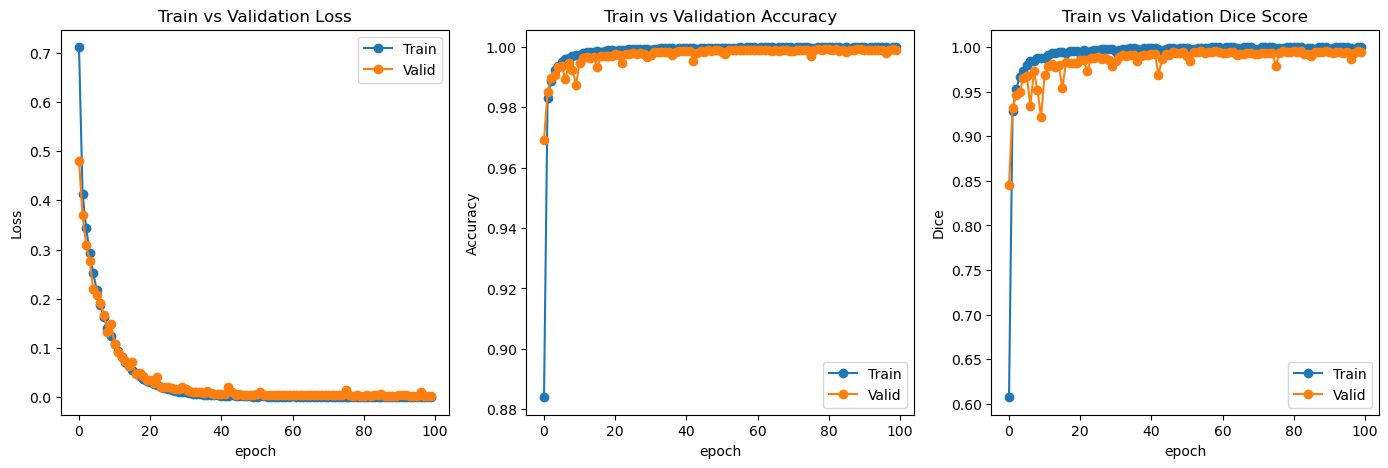

In [21]:
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [22]:
# save output to a folder
my_path = 'output_images/02/val'
if path.exists(my_path) == False:
  os.mkdir(my_path)
my_loader = DataLoader(Objects(validation_img_dir,transform=val_transform), batch_size=1)
save_predictions_as_imgs(my_loader, best_model_2, folder=my_path, device="cuda:0")

C:\Users\-\AppData\Local\Temp\ipykernel_3748\3577722451.py:5: UserWarning: output_images/02/val/1252_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_3748\3577722451.py:5: UserWarning: output_images/02/val/1253_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_3748\3577722451.py:5: UserWarning: output_images/02/val/1254_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_3748\3577722451.py:5: UserWarning: output_images/02/val/1255_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_3748\3577722451.py:5: UserWarning: output_images/02/val/1256_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))


In [23]:
# save model state_dict
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

best_model_state = deepcopy(best_model_2.state_dict())
torch.save(best_model_state, 'model/02/best_model.pth')

# load
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH, weights_only=True))
#model.eval()

## Evaluate the model on test data

In [10]:
test_transform = None

batch_size = 32
test_loader = DataLoader(Objects(testing_img_dir,transform=test_transform), batch_size=batch_size, shuffle=True)
print("Number of images in testing set: ", len(test_loader)*batch_size)
print("Number of batches: ", len(test_loader))

Number of images in testing set:  2240
Number of batches:  70


In [11]:
def test_inference(model, test_loader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Validation device: {device}")
    model.to(device)

    model.eval() # Set the model to evaluation mode
    total_correct = 0
    total_incorrect = 0

    total_dice = 0

    with torch.no_grad():
        for batch_idx, (xi, yi, z) in enumerate(test_loader):
            xi = xi.permute(0,3,1,2)
            xi = xi.to(device)
            #yi = yi.permute(0,3,1,2)
            yi = yi.to(device)
            yp = model(xi)  # Perform forward pass

            preds = torch.argmax(yp, dim=1).squeeze().long()
            total_correct += torch.sum(preds == yi.data)
            total_incorrect += torch.sum(preds != yi.data)

            total_dice += dice(preds, yi, ignore_index=3, average='micro')

    return (total_correct.double() / (total_correct.double() + total_incorrect.double())), (total_dice / len(test_loader))  # Return average accuracy and dice score

In [12]:
num_channels = 3
num_classes = 4
# instantiate model
my_model_test_1 = UnetModel(num_channels, num_classes)
# load model
my_model_test_1.load_state_dict(torch.load('model/01/best_model.pth', weights_only=True))


test_accuracy, test_dice = test_inference(my_model_test_1, test_loader)

Validation device: cuda:0


### Score without augmentation

In [14]:
print(test_accuracy)
print(test_dice)

tensor(0.9984, device='cuda:0', dtype=torch.float64)
tensor(0.9901, device='cuda:0')


In [17]:
# save output to a folder
my_path = 'output_images/01/test'
if path.exists(my_path) == False:
  os.mkdir(my_path)
my_loader = DataLoader(Objects(testing_img_dir,transform=test_transform), batch_size=1)
save_predictions_as_imgs(my_loader, my_model_test_1, folder=my_path, device="cuda:0")

C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/01/test/488_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/01/test/489_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/01/test/490_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/01/test/491_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/01/test/492_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uin

In [18]:
num_channels = 3
num_classes = 4
# instantiate model
my_model_test_2 = UnetModel(num_channels, num_classes)
# load model
my_model_test_2.load_state_dict(torch.load('model/02/best_model.pth', weights_only=True))


test_accuracy, test_dice = test_inference(my_model_test_2, test_loader)

Validation device: cuda:0


### Score with augmentations

In [19]:
print(test_accuracy)
print(test_dice)

tensor(0.9991, device='cuda:0', dtype=torch.float64)
tensor(0.9945, device='cuda:0')


In [20]:
# save output to a folder
my_path = 'output_images/02/test'
if path.exists(my_path) == False:
  os.mkdir(my_path)
my_loader = DataLoader(Objects(testing_img_dir,transform=test_transform), batch_size=1)
save_predictions_as_imgs(my_loader, my_model_test_1, folder=my_path, device="cuda:0")

C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/02/test/488_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/02/test/489_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/02/test/490_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/02/test/491_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uint8))
C:\Users\-\AppData\Local\Temp\ipykernel_20284\3577722451.py:5: UserWarning: output_images/02/test/492_j_gt.jpg is a low contrast image
  imsave(f"{folder}/{idx}_j_gt.jpg" , z.numpy().astype(np.uin